# Predicting H1N1 and seasonal flu vaccine uptake from sociodemographic characteristics and perceived vaccine effectiveness: a machine learning-based approach

Completed by: Bethany Denton

This project was completed for an MSc module 'Data Science with Machine Learning'. The coursework specification asked that we design a research project involving the National 2009 H1N1 Flu Survey data. The only requirements were that we showed evidence of at least two approaches to data preprocessing, handling missing data, and modelling. The following work received a grade of 80%.

___

## Research Motivation

Vaccine hesitancy (a reluctance or refusal of vaccination despite the availability of vaccination services) has been a longstanding barrier that public health campaigns have struggled to overcome. Recent years have seen the re-emergence of viruses in countries where they were thought to have been eliminated, such as measles reappearing within the United Kingdom and USA. This, combined with the world-altering impact of the COVID-19 pandemic, has shown the consequence that decreased vaccine uptake can have upon public health at a national and global level. It has highlighted the need for accurate predictive models, which can be used to inform public health officials and allocate health care resources efficiently.

Predictive models are most useful in a real-world application when they can provide accurate predictions based on data that are 
easy and reliable to collect. However, self-reported behavioral data are more likely to contain inaccurate values, as they require 
the participant to honestly assess their own
behavioral patterns. This work therefore aims to determine whether data from the 
National 2009 H1N1 Flu Survey can be used to train a model for predicting vaccine uptake, without the use of the behavioral features collected in the original survey.

___

## Table of Contents:

- [Prepare Environment and Load Data](#section1)
- [Data Exploration](#section2)
- [Data Preparation](#section3)
- [Hyperparameter Tuning](#section4)
- [Model Validation](#section5)

___

## <a name="section1"></a>Prepare Environment and Load Data

## Dataset:

This study was conducted utilizing data from the National 2009 H1N1 Flu Survey, provided by the United States National Center for Health Statistics, and made available by DrivenData for their Flu Shot Learning competition. Data was collected through a phone survey; responses from 26,707 adult participants are analysed in this paper. Of the 35 features collected, we evaluate the 25 that focus on sociodemographic factors as well as participant opinion on the illnesses’ risk and vaccines’ effectiveness

### Set up the environment

In [1]:
# Installations
!pip install graphviz

# Import Modules
## General
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline

## Classification
from graphviz import Source
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

## Hyperparameter Tuning
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV 

## Performance Metrics
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, f1_score, multilabel_confusion_matrix, precision_score, roc_auc_score

### Helper Functions

In [2]:
# Helper function for printing markdown text
def printmd(string):
    display(Markdown(string))

# Function to view dataset summary and perform basic cleaning
def preliminary_clean(df, dfY=None, print_details=False):
    if print_details:
        printmd('**Dataframe Shape:**')
        print(df.shape)
        print('\n=======\n')
        printmd('**A Brief Overview:**')
        display(df.head(3))
        print('\n=======\n')
        printmd('**Attribute Information:**')
        display(df.info())
        print('\n=======\n')
        printmd('**Displaying Duplicate Values:**')
        display(df[df.duplicated()])
    if dfY is None:
        df.drop_duplicates(inplace=True)
    else:
        duplicates = df[df.duplicated(keep='first')]
        df.drop_duplicates(inplace=True)
        if print_details:
            print(duplicates.index.values)
        dfY.drop(index=list(duplicates.index.values), inplace=True)
    if print_details:
        print('\nDuplicate values have now been dropped. Confirming table of duplicates is empty...')
        display(df[df.duplicated()])
        print('\n=======\n')
        printmd('**Check for Outliers / Data Entry Errors:**')
        display(df.describe())
        print('\n=======\n')


### Import and split the datasets

The feature and labels datasets are imported, and their indices are compared. Before splitting the data, we check whether there has been a bias in sampling for either the features or the labels. This information lets us know whether to stratify the split between training set and test set.

In the end, the test set was isolated using an 80-20 training-test split of the dataset, using stratified sampling based on H1N1 flu vaccination status to account for the class label imbalance.
<br><br>

In [3]:
# Import feature and label datasets, and check if indices are matching. 
df_features_unedited = pd.read_csv('training_set_features.csv', index_col=0)
df_labels_unedited = pd.read_csv('training_set_labels.csv', index_col=0)
if (np.testing.assert_array_equal(df_features_unedited.index.values, df_labels_unedited.index.values)) is None:
    print('Indices match for Feature dataset and Label dataset.')

Indices match for Feature dataset and Label dataset.


<br>**Distribution of features:**

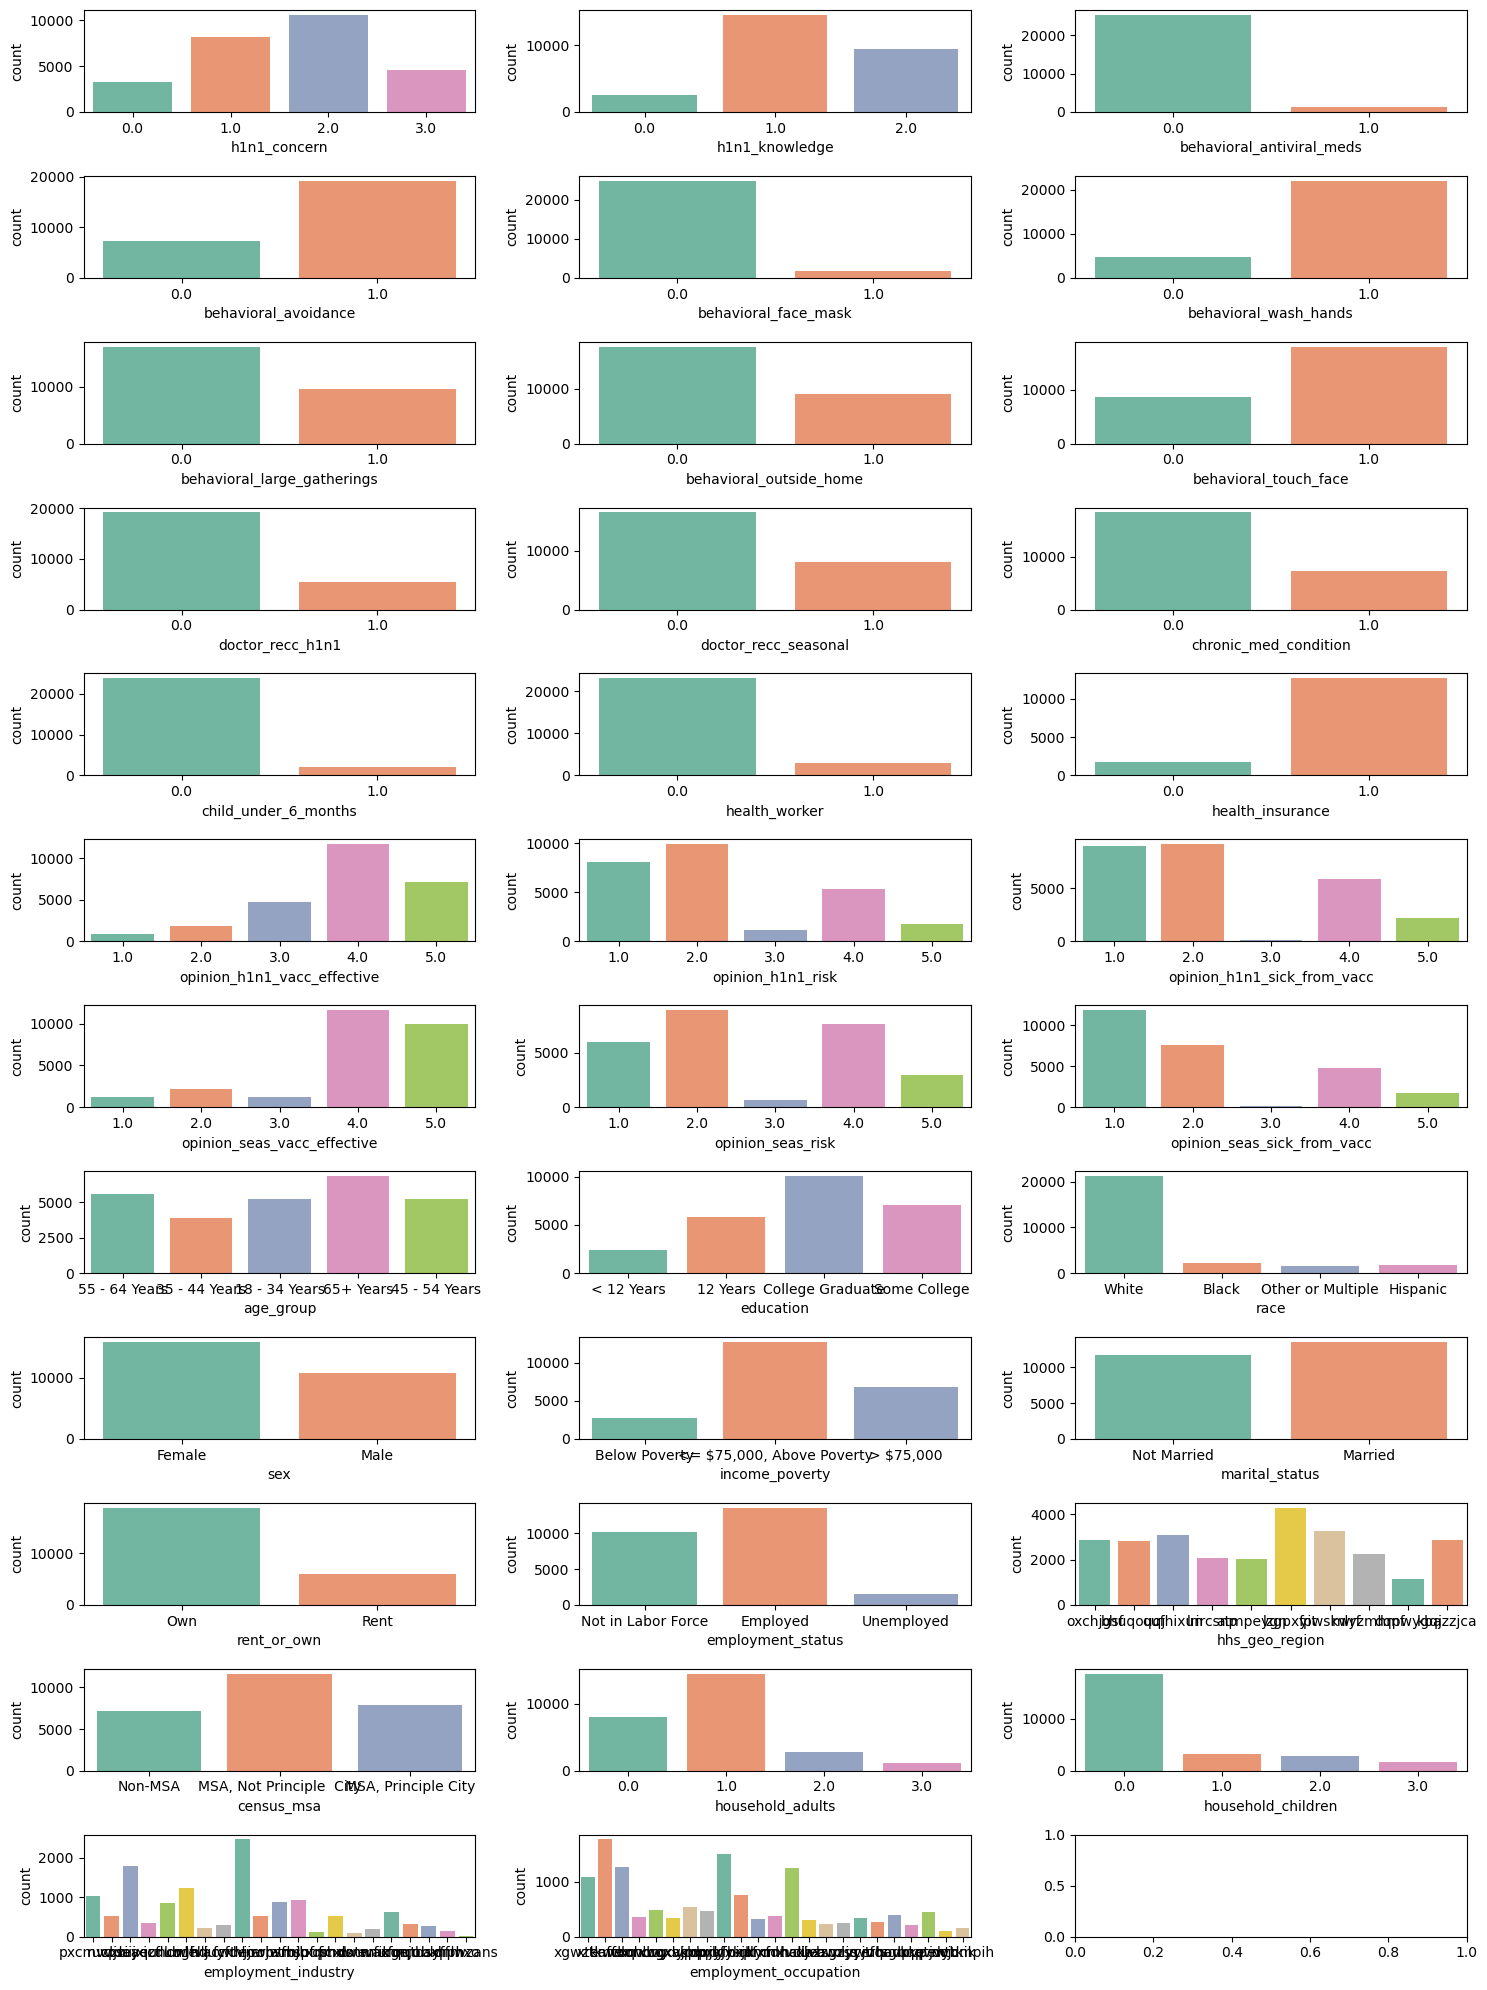

In [4]:
# Check for sampling bias
printmd('<br>**Distribution of features:**')
fig, axs = plt.subplots((len(df_features_unedited.columns)//3)+1, 3, figsize=(15,20))
axis_count=0
for column in df_features_unedited.columns:
    axis = axs[axis_count // 3, axis_count % 3]
    sns.countplot(x=df_features_unedited[column], ax=axis, palette='Set2')
    axis_count+=1
plt.tight_layout()

<br>**Distribution of labels:**

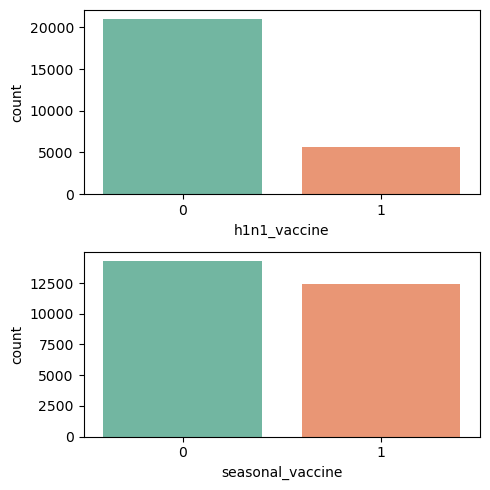

In [5]:
printmd('<br>**Distribution of labels:**')
fig, axs = plt.subplots(2, figsize=(5,5))
axis_count=0
for column in df_labels_unedited.columns:
    axis = axs[axis_count]
    sns.countplot(x=df_labels_unedited[column], ax=axis, palette='Set2')
    axis_count+=1
plt.tight_layout()

In [6]:
# Put aside test set, stratifying based on h1n1_vaccine. Set state so same training set is extracted each time.
X_train, X_test, Y_train, Y_test = train_test_split(df_features_unedited, 
                                                    df_labels_unedited, 
                                                    stratify=df_labels_unedited['h1n1_vaccine'], 
                                                    test_size=0.2, 
                                                    random_state = 42)

### Extract attributes of interest

This project is only interested in using the sociodemographic and opinion-based features to model vaccine uptake. 
As such, these features are extracted from the main dataset. 
<br><br>

In [7]:
columns_of_interest = [
    # Sociodemographic Factors
    'age_group', 
    'education', 
    'race', 
    'sex', 
    'income_poverty', 
    'marital_status', 
    'rent_or_own', 
    'employment_status', 
    'hhs_geo_region',
    'census_msa', 
    'household_adults', 
    'household_children',
    'child_under_6_months',
    'employment_industry', 
    'employment_occupation',
    'health_worker',
    'health_insurance',
    # Vaccine Effectiveness
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc'
]

# Make copies of training datasets for Exploratory Data Analysis.
dfX = X_train[columns_of_interest].copy()
dfY = Y_train.copy()
df = dfX.merge(dfY, how='inner', left_index=True, right_index=True)

### Clean Dataset

This helper function gives an overview of the dataset being worked with, including overall shape and attribute summaries. 

Duplicate entries are removed.

A statistical summary of the resulting dataset is then presented, so that any obvious outliers and data entry errors can be manually identified.
<br><br>

In [8]:
preliminary_clean(df, print_details=True)

**Dataframe Shape:**

(21365, 27)




**A Brief Overview:**

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,...,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
20417,18 - 34 Years,College Graduate,Hispanic,Male,"<= $75,000, Above Poverty",Married,Own,Employed,kbazzjca,"MSA, Not Principle City",...,1.0,2.0,4.0,1.0,2.0,4.0,1.0,5.0,0,1
13969,65+ Years,12 Years,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,atmpeygn,"MSA, Not Principle City",...,2.0,2.0,4.0,4.0,2.0,4.0,4.0,4.0,0,1
24930,45 - 54 Years,College Graduate,White,Female,"> $75,000",Married,Own,Employed,dqpwygqj,"MSA, Not Principle City",...,2.0,2.0,4.0,4.0,1.0,5.0,4.0,1.0,1,1


**Attribute Information:**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21365 entries, 20417 to 26118
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age_group                    21365 non-null  object 
 1   education                    20222 non-null  object 
 2   race                         21365 non-null  object 
 3   sex                          21365 non-null  object 
 4   income_poverty               17824 non-null  object 
 5   marital_status               20230 non-null  object 
 6   rent_or_own                  19716 non-null  object 
 7   employment_status            20179 non-null  object 
 8   hhs_geo_region               21365 non-null  object 
 9   census_msa                   21365 non-null  object 
 10  household_adults             21168 non-null  float64
 11  household_children           21168 non-null  float64
 12  child_under_6_months         20689 non-null  float64
 13  employment_i

None

**Displaying Duplicate Values:**

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,...,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
20065,18 - 34 Years,NaN,White,Female,NaN,NaN,NaN,NaN,qufhixun,"MSA, Not Principle City",...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
12469,18 - 34 Years,NaN,White,Male,NaN,NaN,NaN,NaN,lzgpxyit,Non-MSA,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2054,35 - 44 Years,NaN,White,Male,NaN,NaN,NaN,NaN,fpwskwrf,"MSA, Not Principle City",...,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0



Duplicate values have now been dropped. Confirming table of duplicates is empty...


,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,...,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,


**Check for Outliers / Data Entry Errors:**

,household_adults,household_children,child_under_6_months,health_worker,health_insurance,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,h1n1_vaccine,seasonal_vaccine
count,21168.000000,21168.000000,20689.000000,20703.000000,11516.000000,21286.000000,21272.000000,21039.000000,21041.000000,21034.000000,20978.000000,20944.000000,20919.000000,21362.000000,21362.000000
mean,0.882559,0.541714,0.082991,0.110032,0.876867,1.615052,1.262552,3.850801,2.343567,2.359561,4.023691,2.721304,2.117931,0.212480,0.464142
std,0.754071,0.933444,0.275875,0.312938,0.328604,0.910042,0.618864,1.010089,1.286138,1.365112,1.087339,1.383980,1.335599,0.409072,0.498724
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,0.000000,1.000000
max,3.000000,3.000000,1.000000,1.000000,1.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000


### Identify locations of missing data

Understanding where the missing data lies in the dataset helps us to understand why the data may be missing. 
As missing values will cause issues with most models, it's important to identify and understand them early on.
<br><br>

In [9]:
# View columns with most null-values.
printmd('<br>**Number of null values per column:**')
print(df.isna().sum().sort_values(ascending=False), '\n')

# Check how many employed participants do not have employment information recorded.
printmd("**Employed participants with null employment details:**")
print(df[df['employment_status']=='Employed'].isna().sum()[['employment_industry', 'employment_occupation']])

<br>**Number of null values per column:**

employment_occupation          10793
employment_industry            10687
health_insurance                9846
income_poverty                  3538
rent_or_own                     1646
employment_status               1183
education                       1140
marital_status                  1132
child_under_6_months             673
health_worker                    659
opinion_seas_sick_from_vacc      443
opinion_seas_risk                418
opinion_seas_vacc_effective      384
opinion_h1n1_sick_from_vacc      328
opinion_h1n1_vacc_effective      323
opinion_h1n1_risk                321
household_children               194
household_adults                 194
h1n1_knowledge                    90
h1n1_concern                      76
h1n1_vaccine                       0
age_group                          0
census_msa                         0
hhs_geo_region                     0
sex                                0
race                               0
seasonal_vaccine                   0
d

**Employed participants with null employment details:**

employment_industry      150
employment_occupation    256
dtype: int64


In [10]:
# How many rows have how many null values
printmd("<br>**Count of total missing values per row:**")
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts().sort_index()

<br>**Count of total missing values per row:**

0     5326
1     4700
2     4990
3     4185
4      838
5      211
6       83
7       25
8      321
9       21
10     160
11      33
12      93
13      42
14      38
15      33
16     187
17      16
18      60
dtype: int64

<br>
One source of missing values is in the Employment details of non-employed participants. Although their employment details have been entered as 'null', it is helpful to instead label them as 'unemployed' so they can be separated from employed participants whose employment details are missing.
<br><br>

In [11]:
# Change employment details of non-employed people to 'Unemployed'
df.loc[df['employment_status'].isin(['Not in Labor Force', 'Unemployed']),['employment_occupation', 'employment_industry']] = "Not Employed"
df[df['employment_status'].isin(['Not in Labor Force', 'Unemployed'])][['employment_status','employment_occupation', 'employment_industry']].head(3)

,employment_status,employment_occupation,employment_industry
respondent_id,,,
13969,Not in Labor Force,Not Employed,Not Employed
10998,Not in Labor Force,Not Employed,Not Employed
3418,Not in Labor Force,Not Employed,Not Employed


In [12]:
# This shows that a large number of rows with 2 missing values were just non-employed participants missing employment data. 
printmd("**<br>Count of total missing values per row:**")
df.isnull().sum(axis=1).sort_values(ascending=False).value_counts().sort_index()

**<br>Count of total missing values per row:**

0     9718
1     8716
2     1374
3      306
4       91
5       75
6       56
7       24
8      320
9       21
10     159
11      33
12      93
13      42
14      38
15      33
16     187
17      16
18      60
dtype: int64

In [13]:
printmd("**<br>Number of null values per column:**")
print(df.isna().sum().sort_values(ascending=False), '\n')

**<br>Number of null values per column:**

health_insurance               9846
income_poverty                 3538
rent_or_own                    1646
employment_occupation          1439
employment_industry            1333
employment_status              1183
education                      1140
marital_status                 1132
child_under_6_months            673
health_worker                   659
opinion_seas_sick_from_vacc     443
opinion_seas_risk               418
opinion_seas_vacc_effective     384
opinion_h1n1_sick_from_vacc     328
opinion_h1n1_vacc_effective     323
opinion_h1n1_risk               321
household_children              194
household_adults                194
h1n1_knowledge                   90
h1n1_concern                     76
h1n1_vaccine                      0
age_group                         0
census_msa                        0
hhs_geo_region                    0
sex                               0
race                              0
seasonal_vaccine                  0
dtype: int64 



<br>
A smaller number of entries were missing for the opinion-related attributes. It was decided that these would be imputed as '3' or 'Don't Know'.
<br><br>

In [14]:
# Null values for vaccine imputations decided to be imputed as '3', which refers to the neutral response of 'Don't Know'.
for col in ['opinion_seas_sick_from_vacc', 
            'opinion_seas_risk', 
            'opinion_seas_vacc_effective', 
            'opinion_h1n1_sick_from_vacc',
            'opinion_h1n1_vacc_effective',
            'opinion_h1n1_risk']:
    df.loc[df[col].isna(),col] = 3

### Feature Engineering


In [15]:
# Clarify the ordering of non-numeric ordinal data
df['age_group'] = pd.Categorical(df['age_group'], ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'])
df['education'] = pd.Categorical(df['education'], ['< 12 Years', '12 Years', 'Some College', 'College Graduate'])
df['income_poverty'] = pd.Categorical(df['income_poverty'], ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'])

# Make opinion scores more intuitive. A negative score correspondents with a negative opinion.
df['opinion_h1n1_vacc_effective'] -= 3
df['opinion_h1n1_risk'] -= 3
df['opinion_h1n1_sick_from_vacc'] -= 3
df['opinion_seas_vacc_effective'] -= 3
df['opinion_seas_risk'] -= 3
df['opinion_seas_sick_from_vacc'] -= 3

# Create dummy variables and calculate additional attributes that may be of interest for exploration.
df.insert(df.columns.get_loc('sex')+1, 'is_male', 
          [1 if row['sex'] == "Male" else 0 for index, row in df.iterrows()])
df.insert(df.columns.get_loc('rent_or_own')+1, 'owns_home', 
          [1 if row['rent_or_own'] == "Own" else 0 for index, row in df.iterrows()])
df.insert(df.columns.get_loc('marital_status')+1, 'is_married', 
          [1 if row['marital_status'] == "Married" else 0 for index, row in df.iterrows()])
df.insert(df.columns.get_loc('employment_status')+1, 'is_unemployed', 
          [1 if row['employment_status'] == "Unemployed" else 0 for index, row in df.iterrows()])
df.insert(df.columns.get_loc('income_poverty')+1, 'in_poverty', 
          [1 if row['income_poverty'] == "Below Poverty" else 0 for index, row in df.iterrows()]) 
df.insert(df.columns.get_loc('opinion_seas_sick_from_vacc')+1, 'overall_h1n1_score', (
    df['opinion_h1n1_vacc_effective'] -
    df['opinion_h1n1_risk'] +
    df['opinion_h1n1_sick_from_vacc'])
)         
df.insert(df.columns.get_loc('overall_h1n1_score')+1, 'overall_seas_score', (
    df['opinion_seas_vacc_effective'] -
    df['opinion_seas_risk'] +
    df['opinion_seas_sick_from_vacc'])
)          
df.insert(df.columns.get_loc('overall_seas_score')+1, 'overall_opinion_score', (
    df['opinion_h1n1_vacc_effective'] -
    df['opinion_h1n1_risk'] +
    df['opinion_h1n1_sick_from_vacc'] +
    df['opinion_seas_vacc_effective'] -
    df['opinion_seas_risk'] +
    df['opinion_seas_sick_from_vacc'])
)

# The total number of people in the house excluding the participant.
df.insert(df.columns.get_loc('household_children')+1, 'household_all', df['household_adults'] + df['household_children'])
# Received at least one vaccine
df.insert(df.columns.get_loc('seasonal_vaccine')+1, 
          'any_vaccine', 
          [1 if (row['h1n1_vaccine'] == 1 or row['seasonal_vaccine'] == 1) else 0 for index, row in df.iterrows()])
# Received both h1n1 and seasonal vaccine
df.insert(df.columns.get_loc('any_vaccine')+1, 
          'both_vaccines', 
          [1 if (row['h1n1_vaccine'] == 1 and row['seasonal_vaccine'] == 1) else 0 for index, row in df.iterrows()]) 

## <a name="section2"></a>Data Exploration
Because the training dataset is small, the full dataset can be explored directly.

The dataset was explored through multiple avenues - including correlation analysis and data visualisation - allowing us to see the 
correlation relationship between different variables, as well as the differing distributions for data features across the target labels, and gain insight into how the features relate to one another. Attribute transformation was also iteratively experimented with.

In [16]:
printmd('<br>**Numeric and binary attributes:**')
display(df.describe())

printmd('<br>**Non-binary ordinal and nominal attributes**:')
display(df.describe(include=['object','category']))

<br>**Numeric and binary attributes:**

,is_male,in_poverty,is_married,owns_home,is_unemployed,household_adults,household_children,household_all,child_under_6_months,health_worker,...,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,overall_h1n1_score,overall_seas_score,overall_opinion_score,h1n1_vaccine,seasonal_vaccine,any_vaccine,both_vaccines
count,21362.000000,21362.000000,21362.000000,21362.000000,21362.000000,21168.000000,21168.000000,21168.000000,20689.000000,20703.000000,...,21362.000000,21362.000000,21362.000000,21362.000000,21362.000000,21362.000000,21362.000000,21362.000000,21362.000000,21362.000000
mean,0.405486,0.101816,0.507630,0.700122,0.055379,0.882559,0.541714,1.424272,0.082991,0.110032,...,1.005290,-0.273242,-0.863777,0.853899,0.414755,1.268655,0.212480,0.464142,0.500328,0.176294
std,0.490997,0.302414,0.499953,0.458215,0.228723,0.754071,0.933444,1.309818,0.275875,0.312938,...,1.086072,1.370916,1.327642,1.681083,1.728835,2.801111,0.409072,0.498724,0.500012,0.381079
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2.000000,-2.000000,-2.000000,-6.000000,-6.000000,-12.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,-1.000000,-2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,-1.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,2.000000,2.000000,3.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,6.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,6.000000,6.000000,12.000000,1.000000,1.000000,1.000000,1.000000


<br>**Non-binary ordinal and nominal attributes**:

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,21362,20222,21362,21362,17824,20230,19716,20179,21362,21362,20029,19923
unique,5,4,4,2,3,2,2,3,10,3,22,24
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",Not Employed,Not Employed
freq,5430,8060,16985,12700,10231,10844,14956,10825,3450,9296,9354,9354


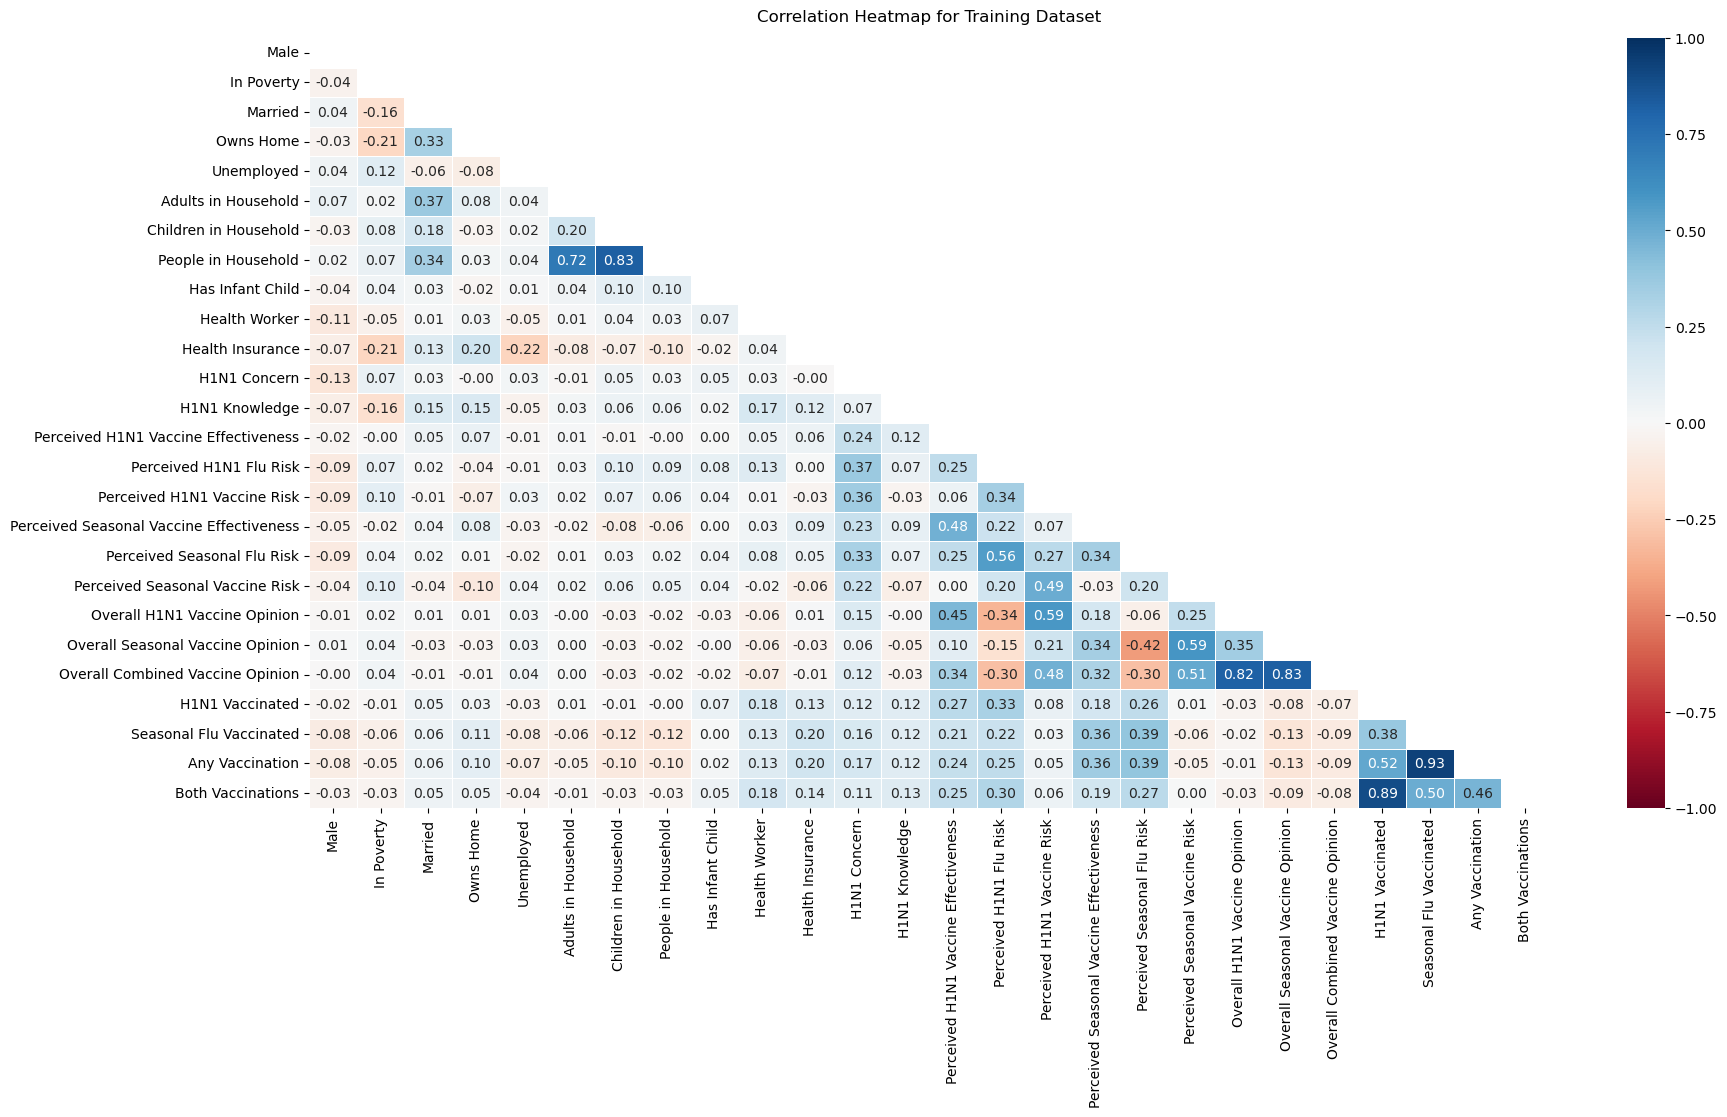

In [17]:
mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype=bool))
axis_labels = [
    'Male',
    'In Poverty',
    'Married',
    'Owns Home',
    'Unemployed',
    'Adults in Household',
    'Children in Household',
    'People in Household',
    'Has Infant Child',
    'Health Worker',
    'Health Insurance',
    'H1N1 Concern',
    'H1N1 Knowledge',
    'Perceived H1N1 Vaccine Effectiveness',
    'Perceived H1N1 Flu Risk',
    'Perceived H1N1 Vaccine Risk',
    'Perceived Seasonal Vaccine Effectiveness',
    'Perceived Seasonal Flu Risk',
    'Perceived Seasonal Vaccine Risk',
    'Overall H1N1 Vaccine Opinion',
    'Overall Seasonal Vaccine Opinion',
    'Overall Combined Vaccine Opinion',
    'H1N1 Vaccinated',
    'Seasonal Flu Vaccinated',
    'Any Vaccination',
    'Both Vaccinations'
]
fig, ax = plt.subplots(figsize=(20,10)) 
heatmap = sns.heatmap(df.corr(numeric_only=True), xticklabels=axis_labels, yticklabels=axis_labels, mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidth=0.5, cmap='RdBu')
heatmap.set_title('Correlation Heatmap for Training Dataset', fontdict={'fontsize':12}, pad=12);


<br>**Distributions for training dataset features:**<br>

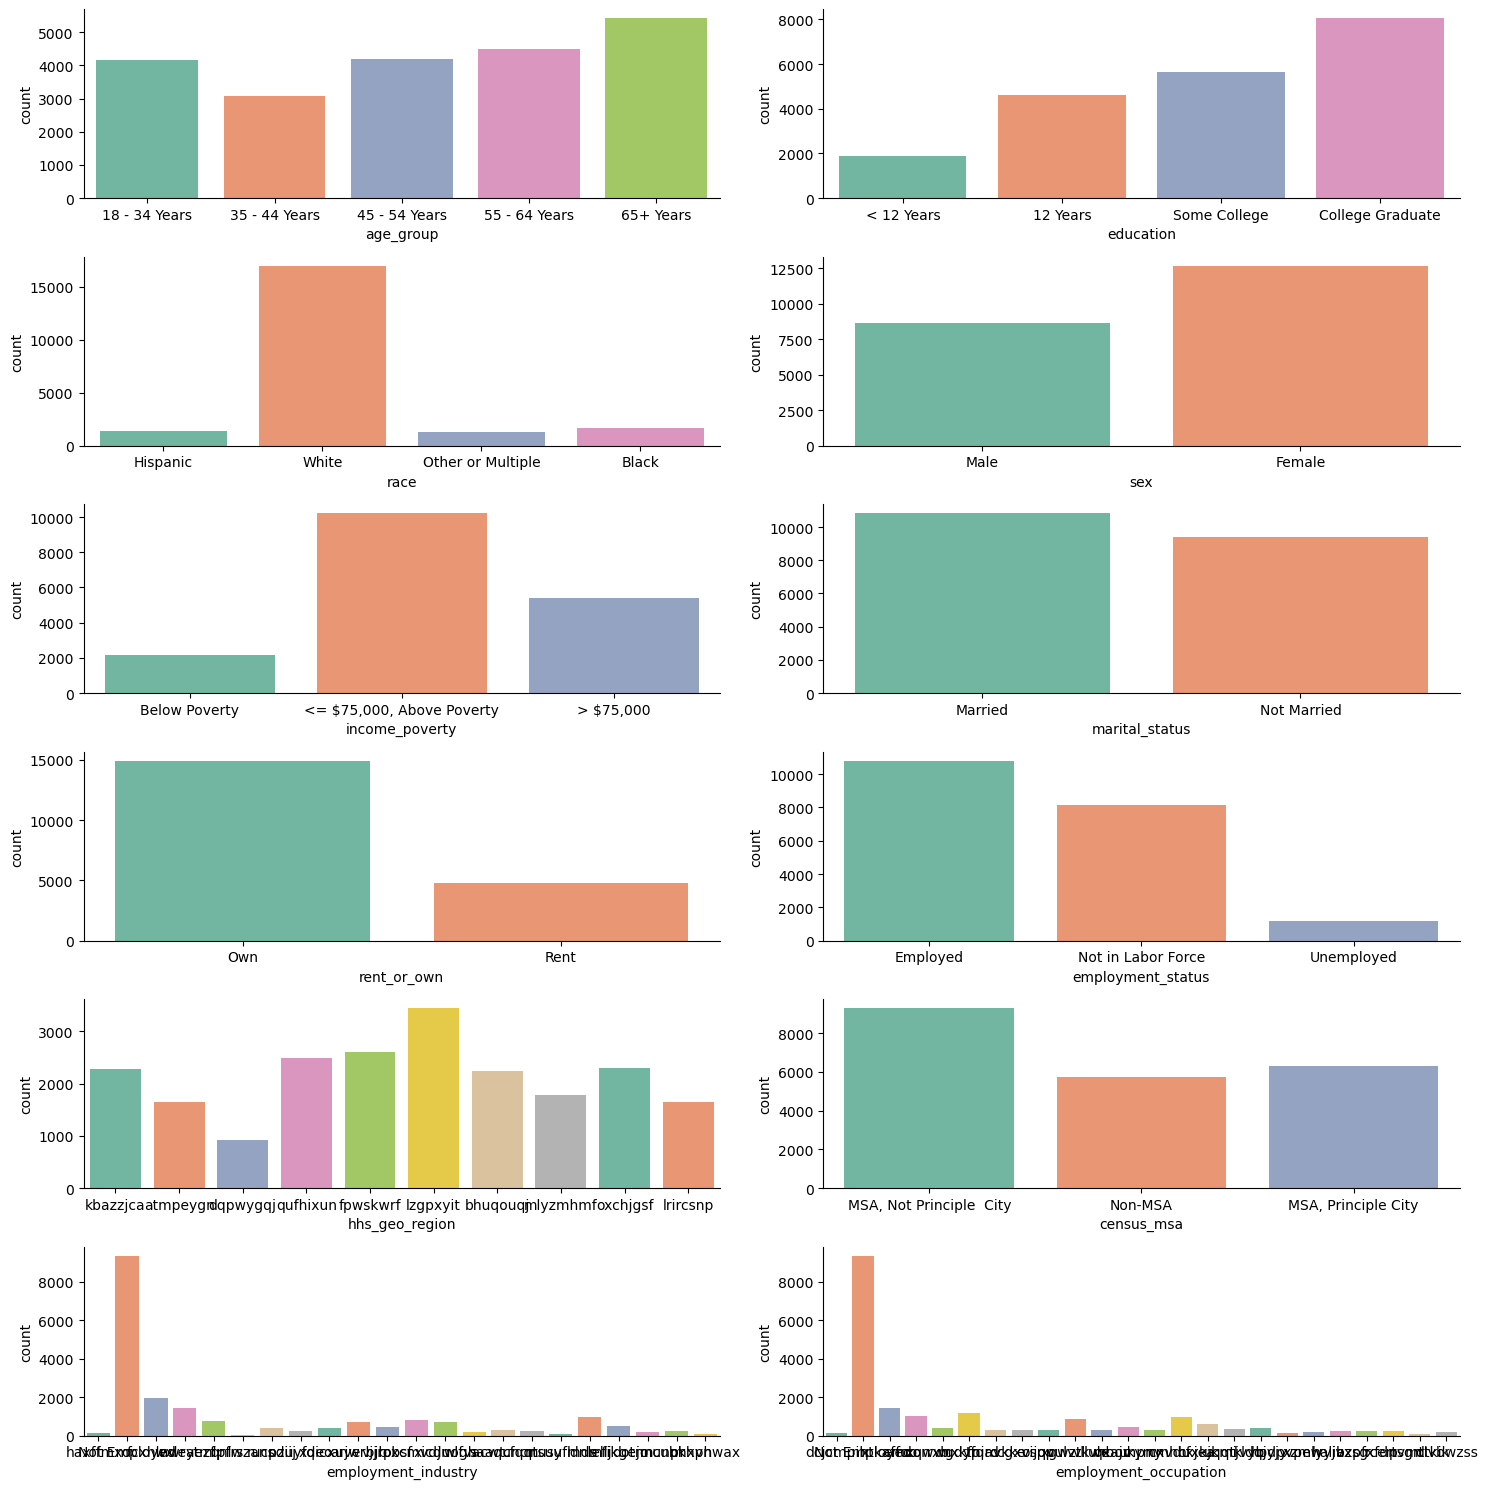

In [18]:
# Visualise categorical distributions
printmd('<br>**Distributions for training dataset features:**<br>')
fig, axs = plt.subplots(6, 2, figsize=(15,15))
axis_count=0
for col in df.select_dtypes(include=['object','category']):
    axis = axs[axis_count // 2, axis_count % 2]
    sns.countplot(x=col, data=df, ax=axis, palette='Set2')
    axis.spines[['right', 'top']].set_visible(False)
    axis_count+=1
plt.tight_layout()

In [19]:
# Investigate how vaccination status is distributed across categorical variables
for label in ['h1n1_vaccine', 'seasonal_vaccine', 'any_vaccine', 'both_vaccines']:
    for col in df.select_dtypes(include=['object','category']):
        display(pd.crosstab(df[label], df[col], normalize='index'))
    print("\n====================================================================\n")

age_group,18 - 34 Years,35 - 44 Years,45 - 54 Years,55 - 64 Years,65+ Years
h1n1_vaccine,,,,,
0,0.199905,0.146347,0.201391,0.203055,0.249302
1,0.174488,0.135272,0.179555,0.238378,0.272307


education,< 12 Years,12 Years,Some College,College Graduate
h1n1_vaccine,,,,
0,0.099862,0.236345,0.282092,0.381701
1,0.073441,0.193072,0.272979,0.460508


race,Black,Hispanic,Other or Multiple,White
h1n1_vaccine,,,,
0,0.084884,0.064614,0.061701,0.788801
1,0.057281,0.065213,0.059044,0.818462


sex,Female,Male
h1n1_vaccine,,
0,0.588599,0.411401
1,0.616435,0.383565


income_poverty,Below Poverty,"<= $75,000, Above Poverty","> $75,000"
h1n1_vaccine,,,
0,0.125457,0.584630,0.289913
1,0.109677,0.535742,0.354581


marital_status,Married,Not Married
h1n1_vaccine,,
0,0.523534,0.476466
1,0.581835,0.418165


rent_or_own,Own,Rent
h1n1_vaccine,,
0,0.751614,0.248386
1,0.784091,0.215909


employment_status,Employed,Not in Labor Force,Unemployed
h1n1_vaccine,,,
0,0.535566,0.402384,0.062051
1,0.539690,0.414256,0.046054


hhs_geo_region,atmpeygn,bhuqouqj,dqpwygqj,fpwskwrf,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun
h1n1_vaccine,,,,,,,,,,
0,0.076205,0.098258,0.045176,0.124413,0.108542,0.077810,0.168400,0.081377,0.104203,0.115616
1,0.079753,0.128883,0.036131,0.113461,0.100022,0.076228,0.135933,0.091210,0.118749,0.119630


census_msa,"MSA, Not Principle City","MSA, Principle City",Non-MSA
h1n1_vaccine,,,
0,0.435594,0.295488,0.268918
1,0.433576,0.298524,0.267900


employment_industry,Not Employed,arjwrbjb,atmlpfrs,cfqqtusy,dotnnunm,fcxhlnwr,haxffmxo,ldnlellj,mcubkhph,mfikgejo,...,phxvnwax,pxcmvdjn,qnlwzans,rucpziij,saaquncn,vjjrobsf,wlfvacwt,wxleyezf,xicduogh,xqicxuve
h1n1_vaccine,,,,,,,,,,,,,,,,,,,,,
0,0.468333,0.033766,0.041524,0.014053,0.009411,0.072555,0.002862,0.051507,0.012591,0.026707,...,0.003497,0.045275,0.000572,0.022638,0.014625,0.023019,0.009411,0.069821,0.038471,0.021938
1,0.462236,0.035789,0.022078,0.008599,0.003951,0.184987,0.016733,0.040437,0.007204,0.017894,...,0.002556,0.027190,0.000697,0.014176,0.010225,0.013944,0.005578,0.082036,0.018592,0.012085


employment_occupation,Not Employed,bxpfxfdn,ccgxvspp,cmhcxjea,dcjcmpih,dlvbwzss,emcorrxb,haliazsg,hfxkjkmi,hodpvpew,...,qxajmpny,rcertsgn,tfqavkke,ukymxvdu,uqqtjvyb,vlluhbov,xgwztkwe,xqwwgdyp,xtkaffoo,xzmlyyjv
h1n1_vaccine,,,,,,,,,,,,,,,,,,,,,
0,0.470547,0.012011,0.014695,0.032456,0.002875,0.008178,0.050473,0.009008,0.032775,0.007092,...,0.024534,0.013353,0.017122,0.016036,0.019678,0.014567,0.048556,0.021147,0.072962,0.010542
1,0.465699,0.016390,0.009834,0.108406,0.016858,0.011941,0.056895,0.020838,0.022477,0.010302,...,0.010770,0.004449,0.009834,0.013112,0.009600,0.012643,0.029501,0.011473,0.067432,0.009365


age_group,18 - 34 Years,35 - 44 Years,45 - 54 Years,55 - 64 Years,65+ Years
seasonal_vaccine,,,,,
0,0.260330,0.171137,0.219446,0.193064,0.156023
1,0.118507,0.112658,0.170550,0.230761,0.367524


education,< 12 Years,12 Years,Some College,College Graduate
seasonal_vaccine,,,,
0,0.105283,0.236142,0.290737,0.367839
1,0.081626,0.216790,0.268110,0.433474


race,Black,Hispanic,Other or Multiple,White
seasonal_vaccine,,,,
0,0.095134,0.079409,0.067267,0.758190
1,0.060414,0.047806,0.054060,0.837721


sex,Female,Male
seasonal_vaccine,,
0,0.558574,0.441426
1,0.636006,0.363994


income_poverty,Below Poverty,"<= $75,000, Above Poverty","> $75,000"
seasonal_vaccine,,,
0,0.143806,0.566579,0.289615
1,0.097254,0.582444,0.320302


marital_status,Married,Not Married
seasonal_vaccine,,
0,0.511442,0.488558
1,0.563924,0.436076


rent_or_own,Own,Rent
seasonal_vaccine,,
0,0.714163,0.285837
1,0.809013,0.190987


employment_status,Employed,Not in Labor Force,Unemployed
seasonal_vaccine,,,
0,0.585696,0.337747,0.076557
1,0.480592,0.481121,0.038287


hhs_geo_region,atmpeygn,bhuqouqj,dqpwygqj,fpwskwrf,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun
seasonal_vaccine,,,,,,,,,,
0,0.073993,0.097493,0.045601,0.121517,0.102734,0.085088,0.166070,0.085350,0.106578,0.115576
1,0.080383,0.113162,0.040545,0.122743,0.111346,0.068684,0.156228,0.081291,0.108119,0.117499


census_msa,"MSA, Not Principle City","MSA, Principle City",Non-MSA
seasonal_vaccine,,,
0,0.424827,0.302874,0.272298
1,0.447100,0.288351,0.264549


employment_industry,Not Employed,arjwrbjb,atmlpfrs,cfqqtusy,dotnnunm,fcxhlnwr,haxffmxo,ldnlellj,mcubkhph,mfikgejo,...,phxvnwax,pxcmvdjn,qnlwzans,rucpziij,saaquncn,vjjrobsf,wlfvacwt,wxleyezf,xicduogh,xqicxuve
seasonal_vaccine,,,,,,,,,,,,,,,,,,,,,
0,0.418047,0.035755,0.044976,0.016090,0.010162,0.066146,0.001976,0.055984,0.014584,0.026440,...,0.004046,0.050056,0.000565,0.030486,0.018442,0.027192,0.010162,0.074332,0.049304,0.025028
1,0.522391,0.032443,0.028720,0.009254,0.006063,0.131263,0.010212,0.041379,0.007872,0.022976,...,0.002447,0.031592,0.000638,0.009893,0.008297,0.014147,0.006808,0.070312,0.017126,0.013935


employment_occupation,Not Employed,bxpfxfdn,ccgxvspp,cmhcxjea,dcjcmpih,dlvbwzss,emcorrxb,haliazsg,hfxkjkmi,hodpvpew,...,qxajmpny,rcertsgn,tfqavkke,ukymxvdu,uqqtjvyb,vlluhbov,xgwztkwe,xqwwgdyp,xtkaffoo,xzmlyyjv
seasonal_vaccine,,,,,,,,,,,,,,,,,,,,,
0,0.420142,0.013522,0.017021,0.028747,0.001986,0.009929,0.053333,0.008700,0.033191,0.007565,...,0.032719,0.015035,0.021182,0.019196,0.024113,0.017400,0.055508,0.024681,0.078203,0.009929
1,0.525353,0.012302,0.009842,0.071352,0.010270,0.007916,0.050171,0.014763,0.027599,0.008023,...,0.008986,0.007381,0.009200,0.011125,0.010056,0.010484,0.031985,0.012730,0.064506,0.010697


age_group,18 - 34 Years,35 - 44 Years,45 - 54 Years,55 - 64 Years,65+ Years
any_vaccine,,,,,
0,0.255949,0.170227,0.222035,0.194491,0.157298
1,0.133140,0.117796,0.171501,0.226609,0.350954


education,< 12 Years,12 Years,Some College,College Graduate
any_vaccine,,,,
0,0.104618,0.236661,0.292710,0.366012
1,0.083963,0.217656,0.267778,0.430603


race,Black,Hispanic,Other or Multiple,White
any_vaccine,,,,
0,0.095185,0.075511,0.066329,0.762975
1,0.062874,0.053986,0.055951,0.827189


sex,Female,Male
any_vaccine,,
0,0.556586,0.443414
1,0.632391,0.367609


income_poverty,Below Poverty,"<= $75,000, Above Poverty","> $75,000"
any_vaccine,,,
0,0.142049,0.570232,0.287719
1,0.102347,0.577706,0.319947


marital_status,Married,Not Married
any_vaccine,,
0,0.509730,0.490270
1,0.561857,0.438143


rent_or_own,Own,Rent
any_vaccine,,
0,0.716245,0.283755
1,0.800141,0.199859


employment_status,Employed,Not in Labor Force,Unemployed
any_vaccine,,,
0,0.586635,0.337035,0.076331
1,0.487185,0.471570,0.041245


hhs_geo_region,atmpeygn,bhuqouqj,dqpwygqj,fpwskwrf,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun
any_vaccine,,,,,,,,,,
0,0.074855,0.095840,0.046562,0.121135,0.103710,0.084411,0.167229,0.084130,0.107270,0.114859
1,0.079061,0.113679,0.039951,0.123035,0.109749,0.070546,0.155782,0.082803,0.107317,0.118076


census_msa,"MSA, Not Principle City","MSA, Principle City",Non-MSA
any_vaccine,,,
0,0.425239,0.300450,0.274311
1,0.445079,0.291823,0.263099


employment_industry,Not Employed,arjwrbjb,atmlpfrs,cfqqtusy,dotnnunm,fcxhlnwr,haxffmxo,ldnlellj,mcubkhph,mfikgejo,...,phxvnwax,pxcmvdjn,qnlwzans,rucpziij,saaquncn,vjjrobsf,wlfvacwt,wxleyezf,xicduogh,xqicxuve
any_vaccine,,,,,,,,,,,,,,,,,,,,,
0,0.417205,0.035642,0.045739,0.016559,0.010602,0.062904,0.001212,0.056947,0.014842,0.026252,...,0.004039,0.051191,0.000505,0.030190,0.018881,0.027262,0.010400,0.072193,0.051090,0.025747
1,0.515753,0.032790,0.029136,0.009284,0.005926,0.129778,0.010370,0.041481,0.008099,0.023407,...,0.002568,0.031802,0.000691,0.011654,0.008593,0.015012,0.006815,0.072691,0.017679,0.014025


employment_occupation,Not Employed,bxpfxfdn,ccgxvspp,cmhcxjea,dcjcmpih,dlvbwzss,emcorrxb,haliazsg,hfxkjkmi,hodpvpew,...,qxajmpny,rcertsgn,tfqavkke,ukymxvdu,uqqtjvyb,vlluhbov,xgwztkwe,xqwwgdyp,xtkaffoo,xzmlyyjv
any_vaccine,,,,,,,,,,,,,,,,,,,,,
0,0.419280,0.013496,0.017453,0.026687,0.001218,0.009437,0.051953,0.008321,0.034196,0.007509,...,0.033384,0.015830,0.021005,0.019381,0.024252,0.017656,0.056012,0.024759,0.079655,0.010249
1,0.518673,0.012416,0.009932,0.070322,0.010429,0.008542,0.051748,0.014700,0.027016,0.008045,...,0.010032,0.007151,0.010230,0.011522,0.010926,0.010727,0.033174,0.013508,0.064064,0.010330


age_group,18 - 34 Years,35 - 44 Years,45 - 54 Years,55 - 64 Years,65+ Years
both_vaccines,,,,,
0,0.205217,0.147988,0.200614,0.201750,0.244431
1,0.144450,0.125332,0.178704,0.251726,0.299788


education,< 12 Years,12 Years,Some College,College Graduate
both_vaccines,,,,
0,0.100499,0.236023,0.281278,0.382199
1,0.065187,0.185853,0.274896,0.474064


race,Black,Hispanic,Other or Multiple,White
both_vaccines,,,,
0,0.085303,0.067629,0.062514,0.784553
1,0.049655,0.051248,0.054700,0.844397


sex,Female,Male
both_vaccines,,
0,0.588486,0.411514
1,0.622677,0.377323


income_poverty,Below Poverty,"<= $75,000, Above Poverty","> $75,000"
both_vaccines,,,
0,0.127337,0.581615,0.291047
1,0.097984,0.539535,0.362481


marital_status,Married,Not Married
both_vaccines,,
0,0.524036,0.475964
1,0.591300,0.408700


rent_or_own,Own,Rent
both_vaccines,,
0,0.748704,0.251296
1,0.804162,0.195838


employment_status,Employed,Not in Labor Force,Unemployed
both_vaccines,,,
0,0.537200,0.399976,0.062824
1,0.532981,0.427776,0.039243


hhs_geo_region,atmpeygn,bhuqouqj,dqpwygqj,fpwskwrf,kbazzjca,lrircsnp,lzgpxyit,mlyzmhmf,oxchjgsf,qufhixun
both_vaccines,,,,,,,,,,
0,0.075585,0.099227,0.044612,0.124517,0.107695,0.078541,0.167595,0.082291,0.103887,0.116049
1,0.083378,0.130643,0.036909,0.110728,0.102230,0.072491,0.133032,0.088954,0.123208,0.118428


census_msa,"MSA, Not Principle City","MSA, Principle City",Non-MSA
both_vaccines,,,
0,0.434872,0.297283,0.267845
1,0.436537,0.290759,0.272703


employment_industry,Not Employed,arjwrbjb,atmlpfrs,cfqqtusy,dotnnunm,fcxhlnwr,haxffmxo,ldnlellj,mcubkhph,mfikgejo,...,phxvnwax,pxcmvdjn,qnlwzans,rucpziij,saaquncn,vjjrobsf,wlfvacwt,wxleyezf,xicduogh,xqicxuve
both_vaccines,,,,,,,,,,,,,,,,,,,,,
0,0.466626,0.033921,0.041216,0.013860,0.009179,0.074225,0.003283,0.051125,0.012523,0.026809,...,0.003526,0.044802,0.000608,0.023161,0.014529,0.023161,0.009301,0.071307,0.037872,0.021641
1,0.468846,0.035485,0.019559,0.008382,0.003912,0.200056,0.017603,0.039955,0.006426,0.015647,...,0.002235,0.025706,0.000559,0.010059,0.009779,0.011456,0.005309,0.077675,0.017323,0.011456


employment_occupation,Not Employed,bxpfxfdn,ccgxvspp,cmhcxjea,dcjcmpih,dlvbwzss,emcorrxb,haliazsg,hfxkjkmi,hodpvpew,...,qxajmpny,rcertsgn,tfqavkke,ukymxvdu,uqqtjvyb,vlluhbov,xgwztkwe,xqwwgdyp,xtkaffoo,xzmlyyjv
both_vaccines,,,,,,,,,,,,,,,,,,,,,
0,0.468849,0.012094,0.014537,0.033533,0.003298,0.008551,0.051429,0.009223,0.032189,0.007146,...,0.024493,0.012949,0.017408,0.016064,0.01979,0.014537,0.048559,0.021256,0.072319,0.010323
1,0.472543,0.016897,0.009575,0.118840,0.017741,0.010983,0.053788,0.022247,0.023092,0.010701,...,0.008167,0.004506,0.007040,0.012391,0.00704,0.012391,0.025627,0.009012,0.069276,0.010138


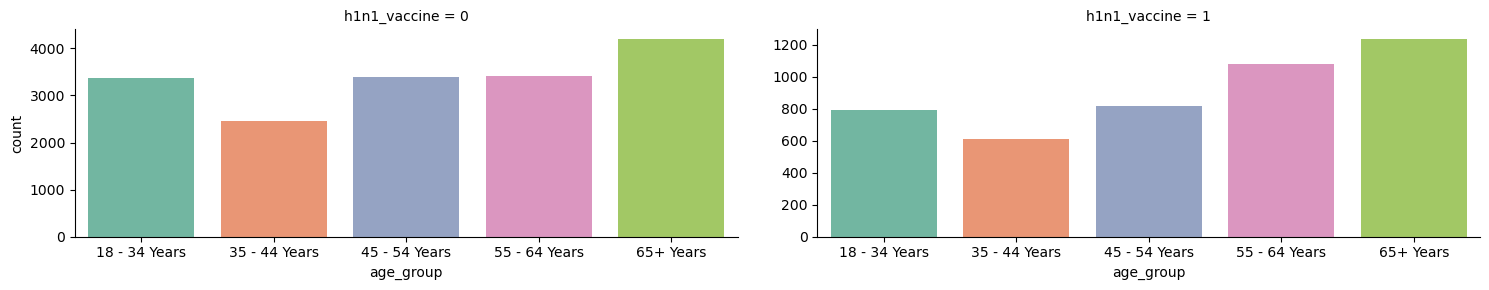

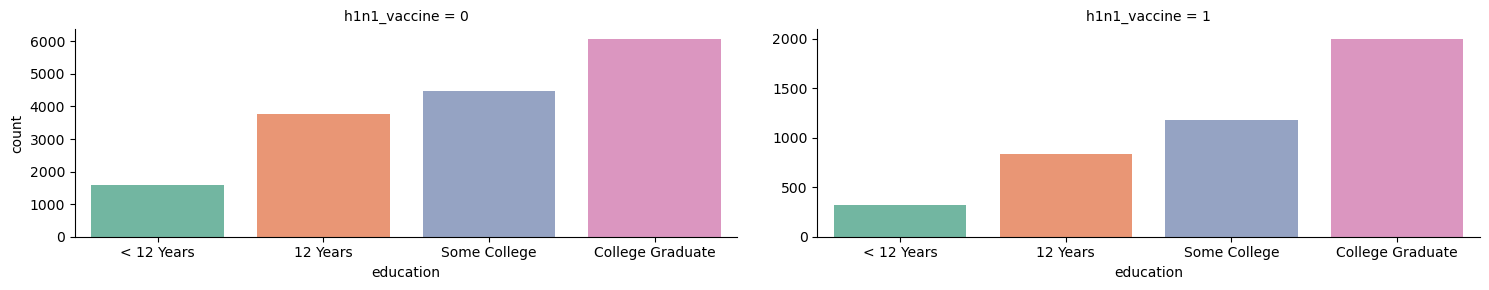

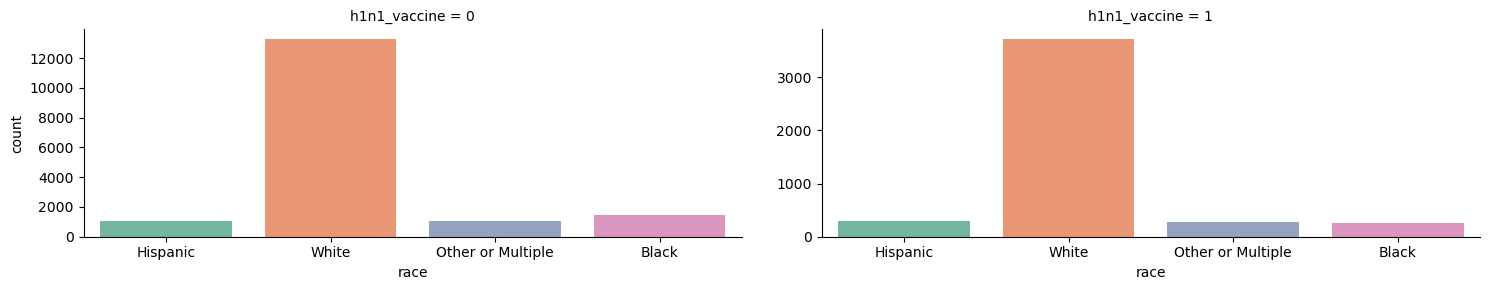

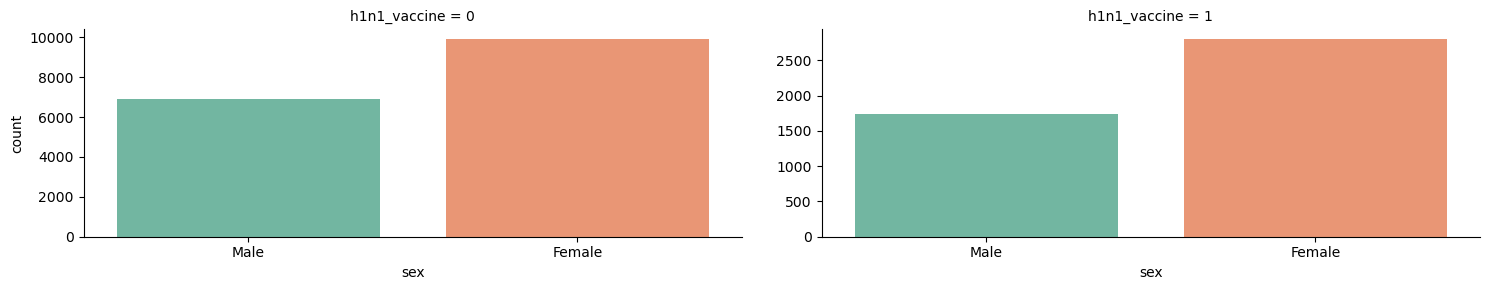

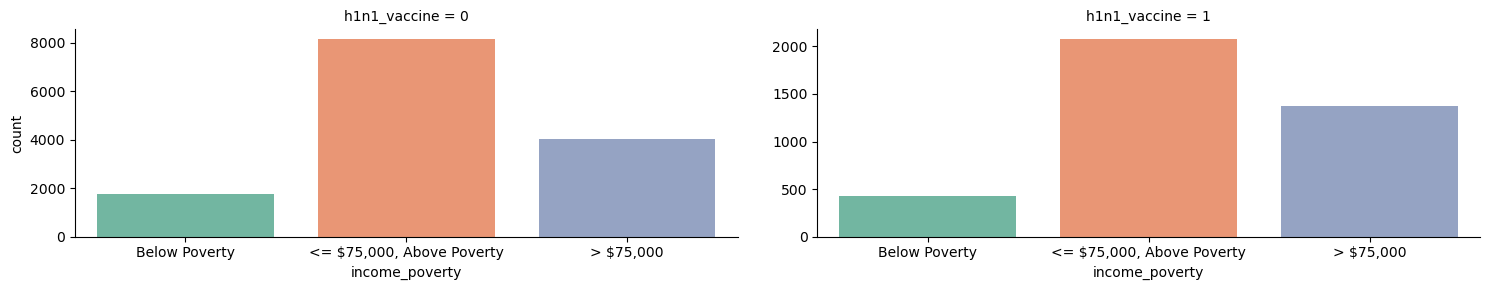

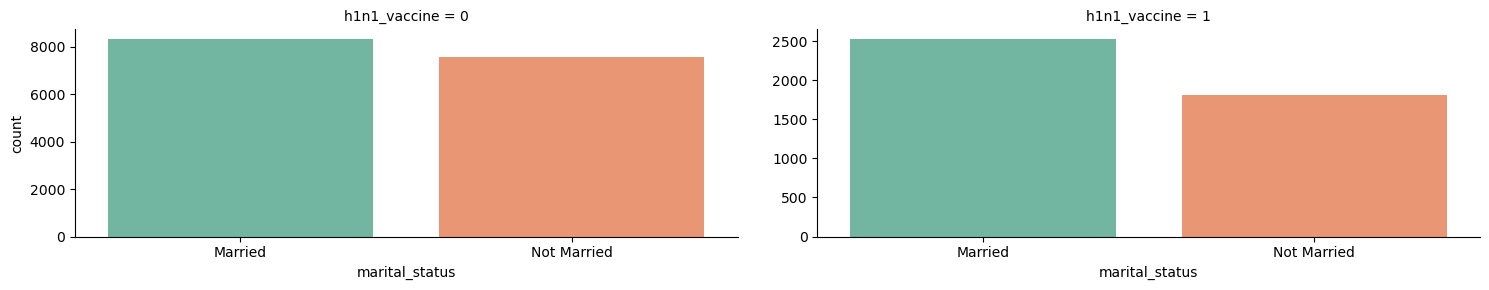

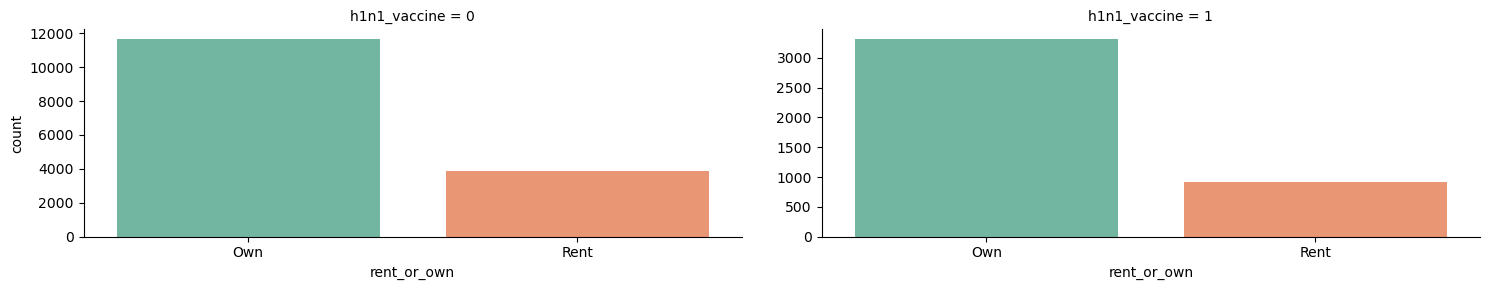

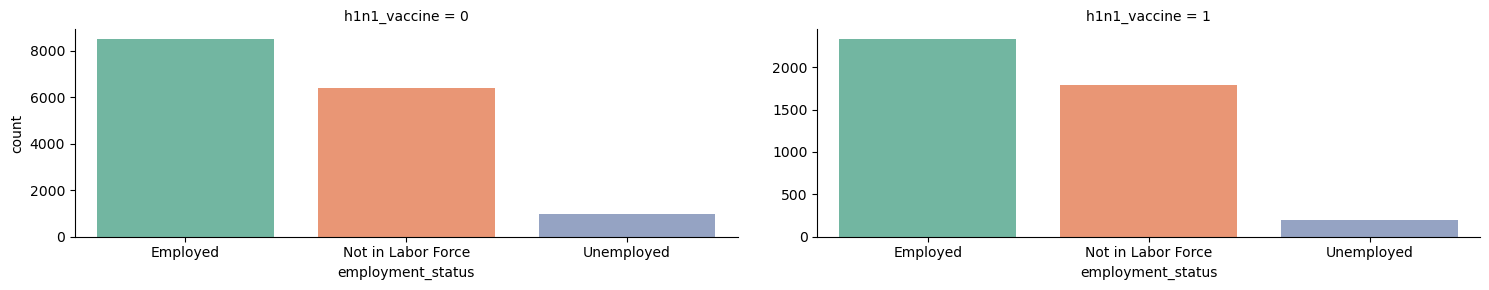

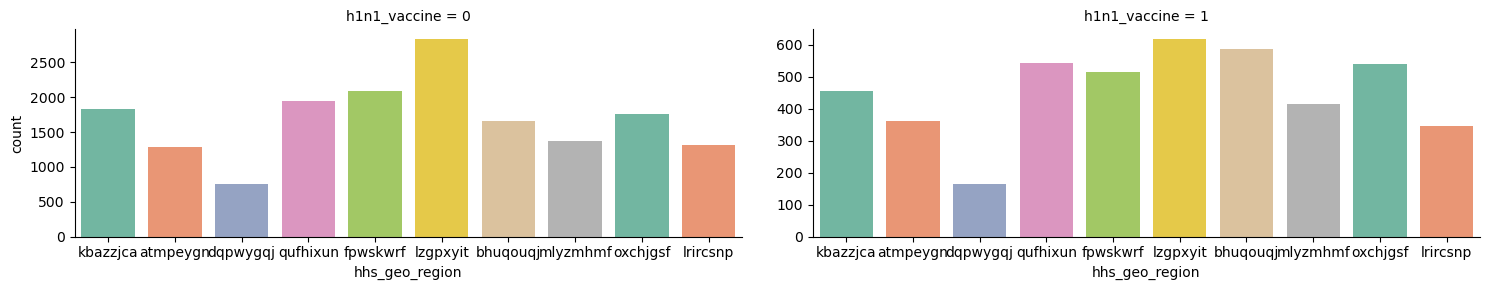

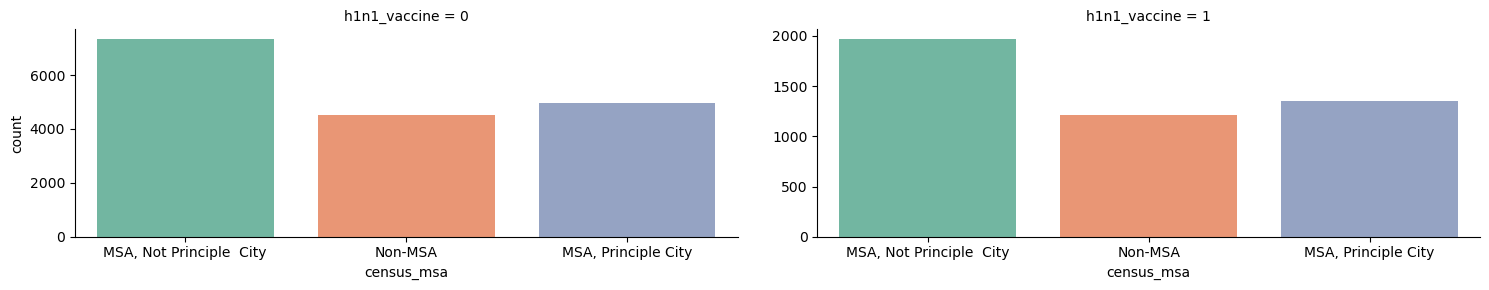

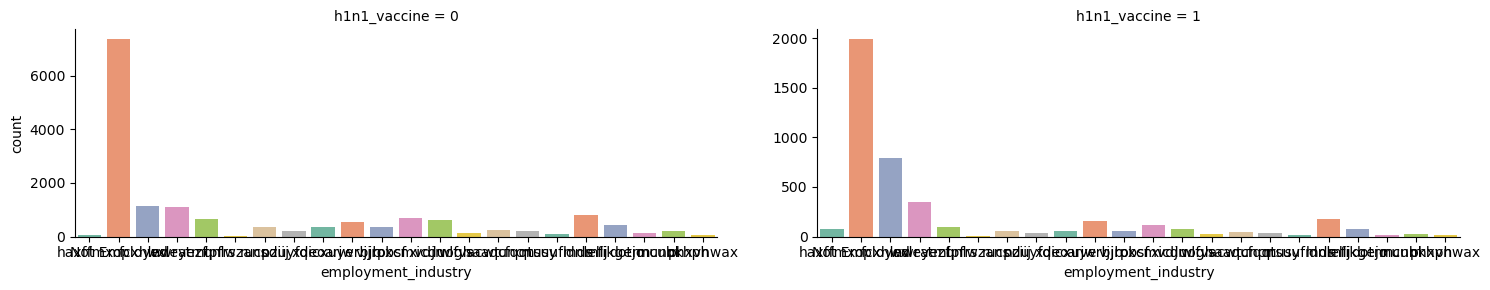

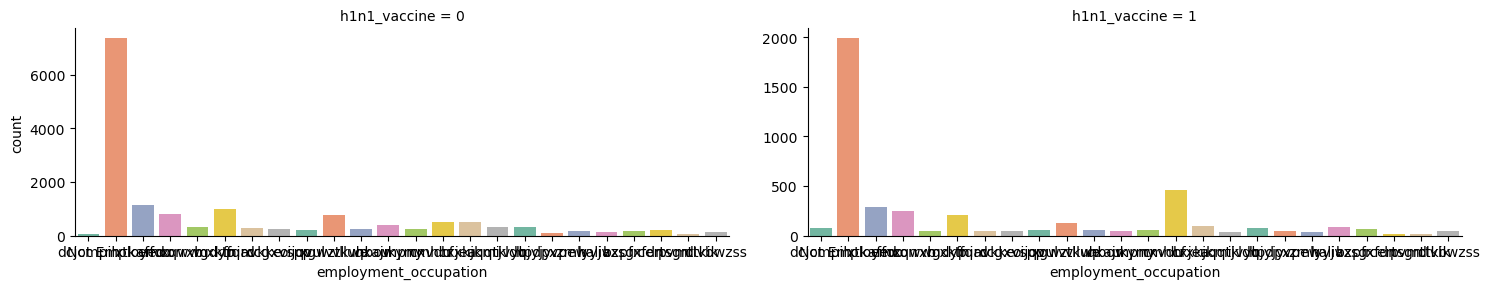

In [20]:
# Visualise how vaccination status is distributed across categorical variables
for col in df.select_dtypes(include=['object','category']):
    sns.catplot(x = col, kind='count', col='h1n1_vaccine', data=df, sharey=False, height=3, aspect=2.5, palette='Set2')
plt.tight_layout()

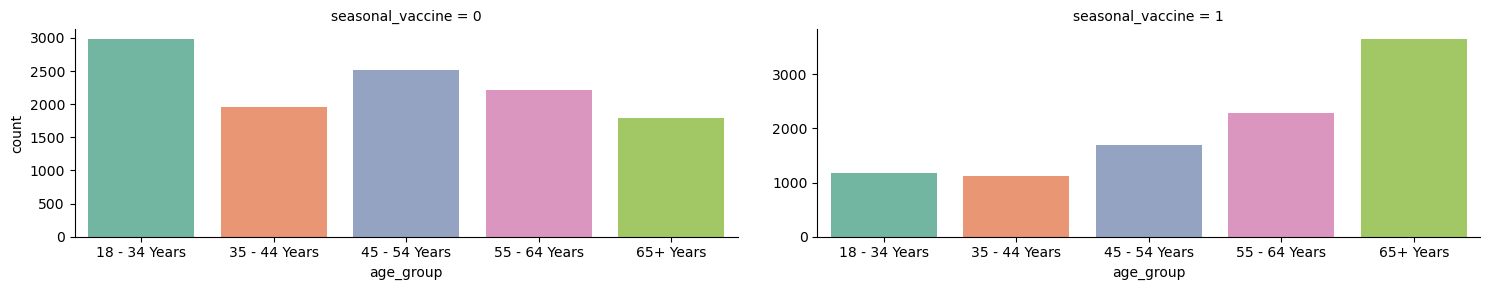

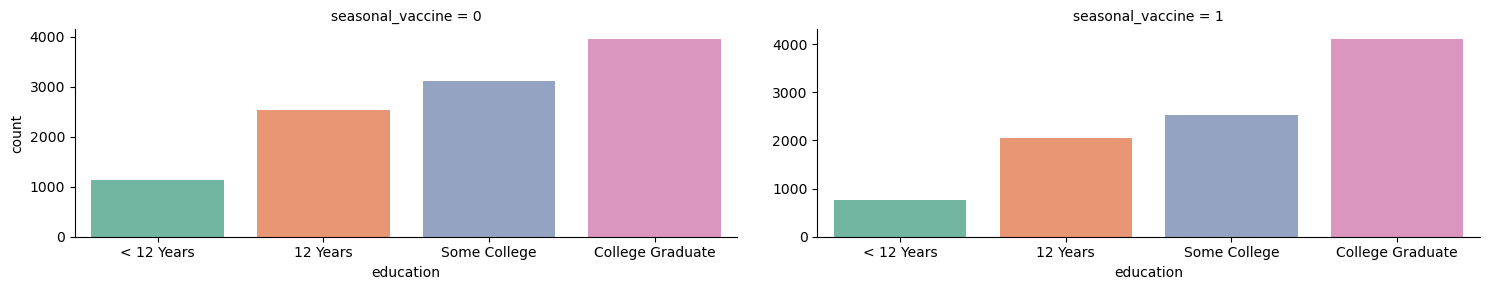

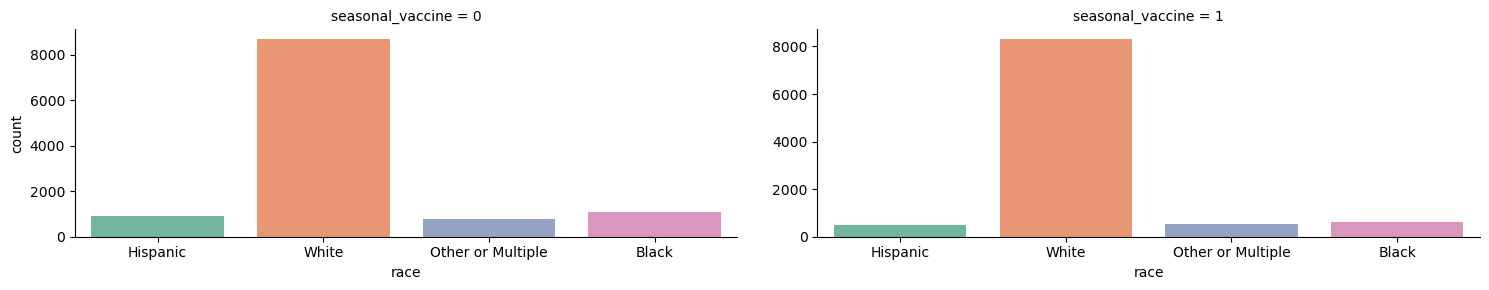

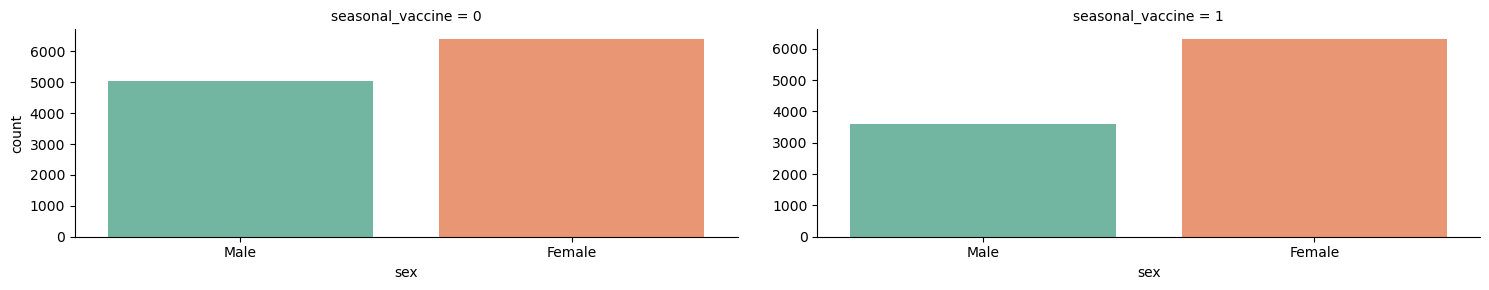

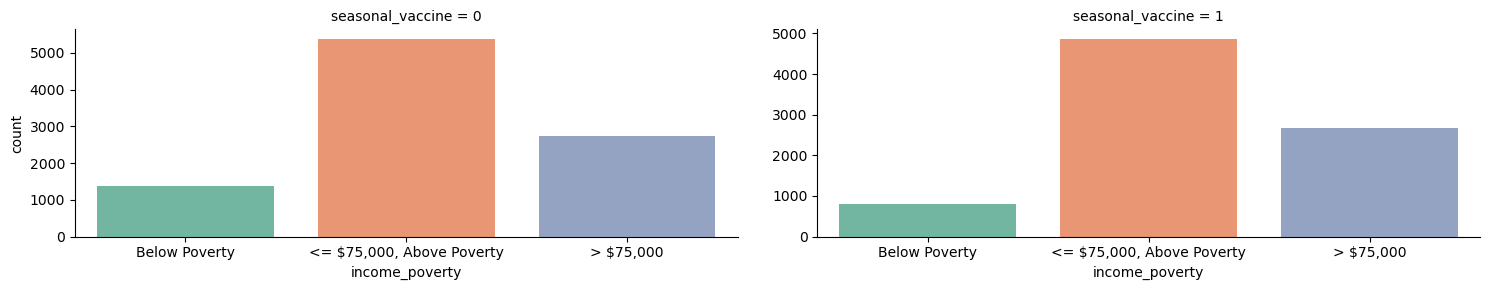

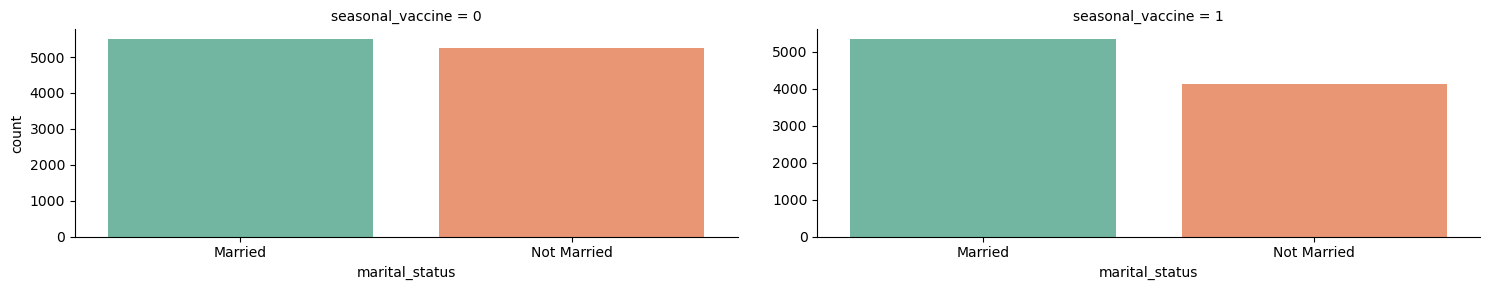

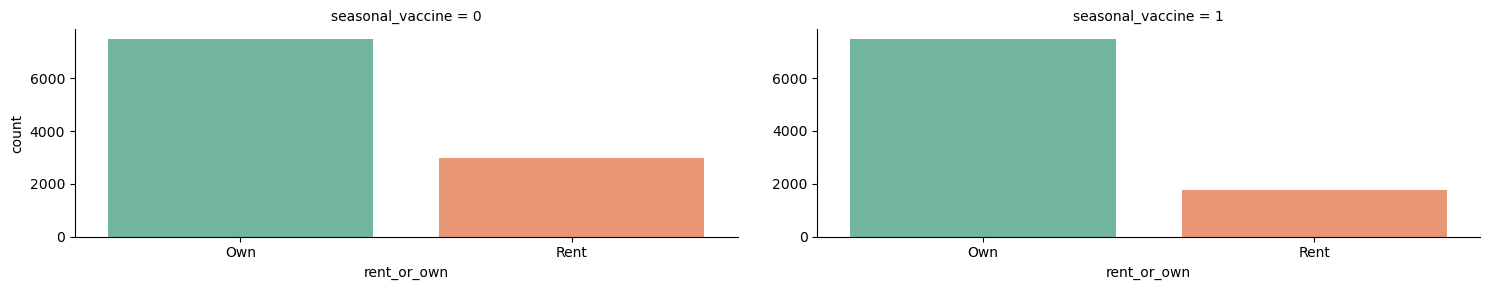

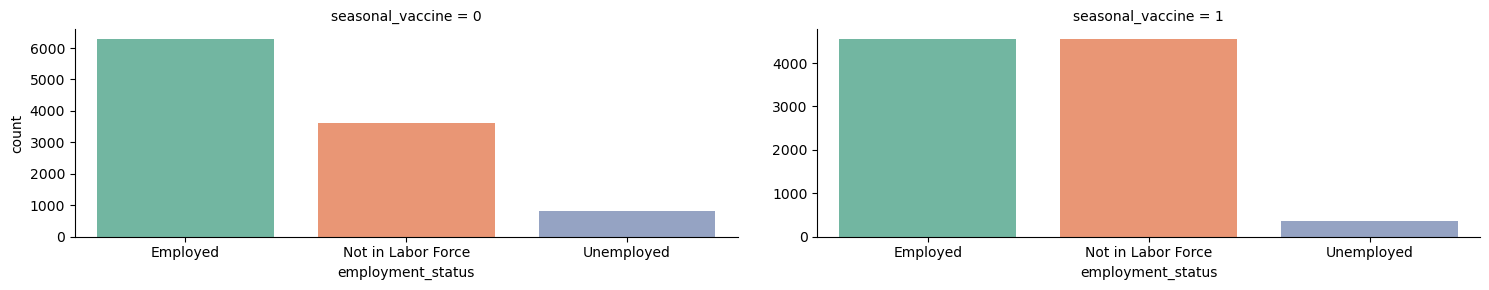

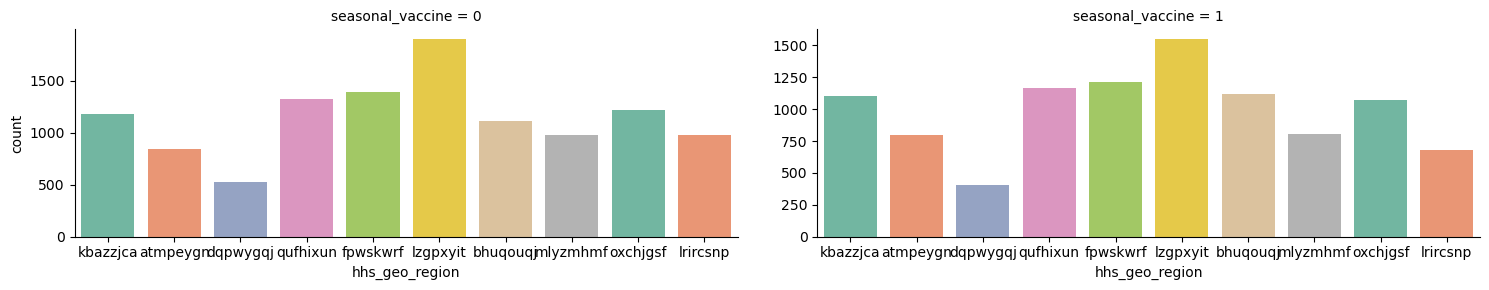

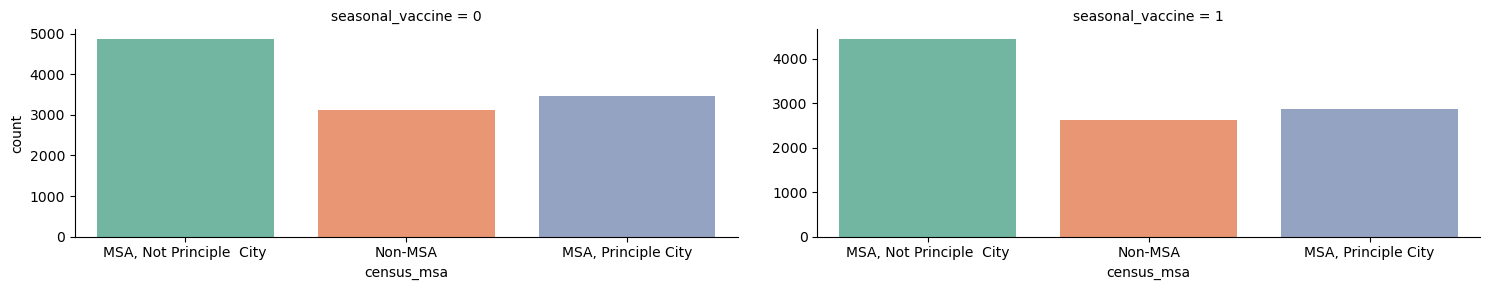

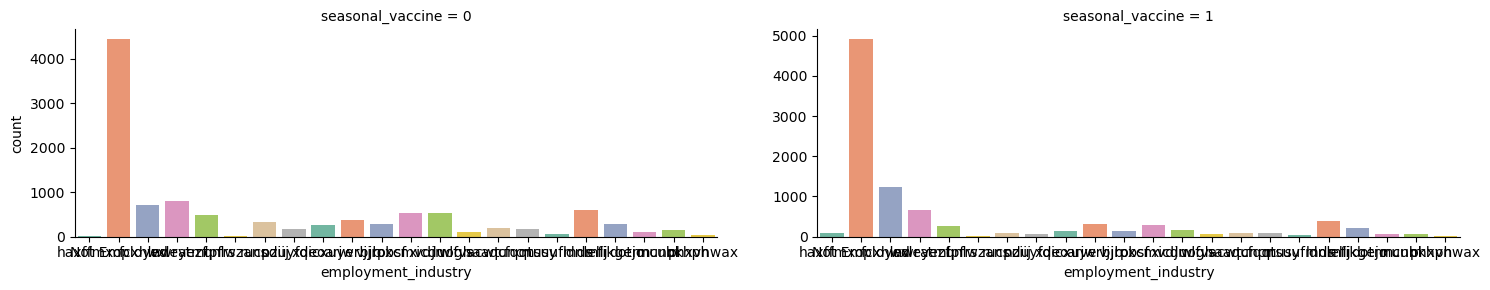

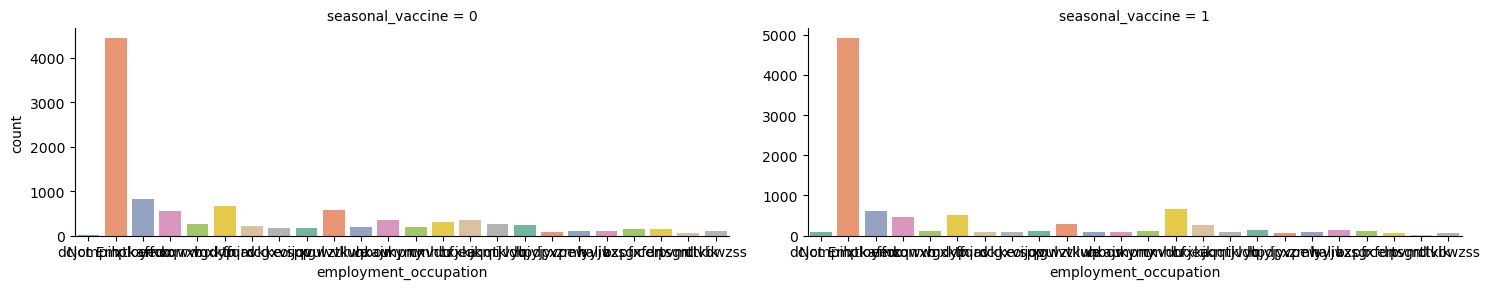

In [21]:
for col in df.select_dtypes(include=['object','category']):
    sns.catplot(x = col, kind='count', col='seasonal_vaccine', data=df, sharey=False, height=3, aspect=2.5, palette='Set2')
plt.tight_layout()

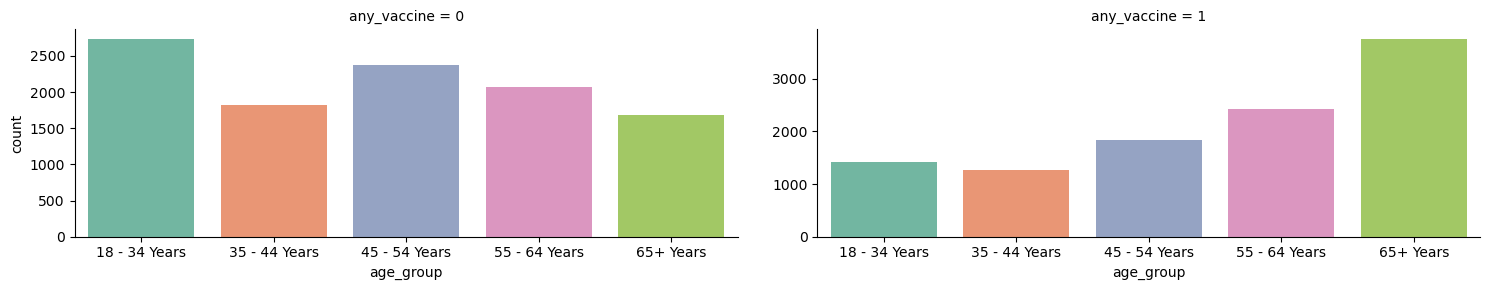

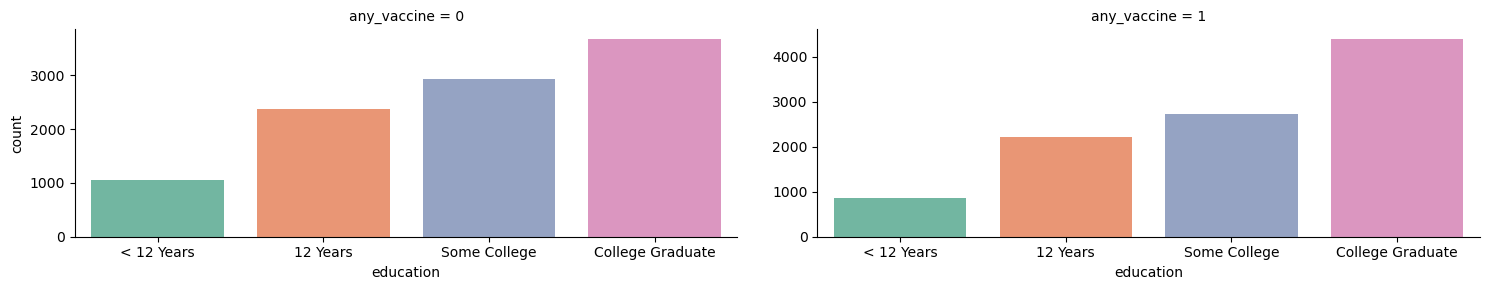

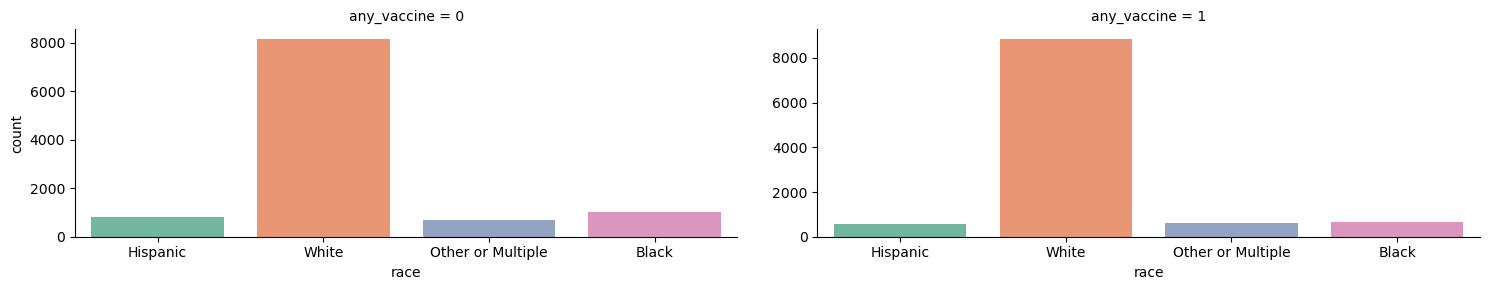

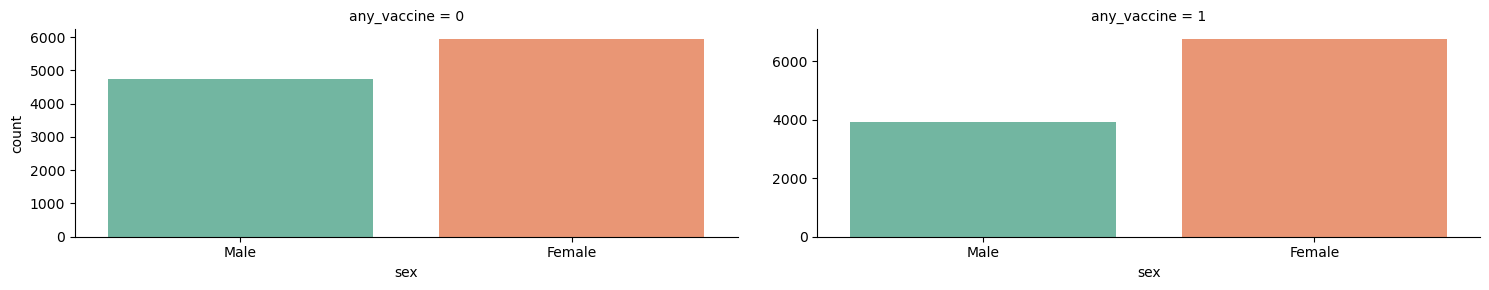

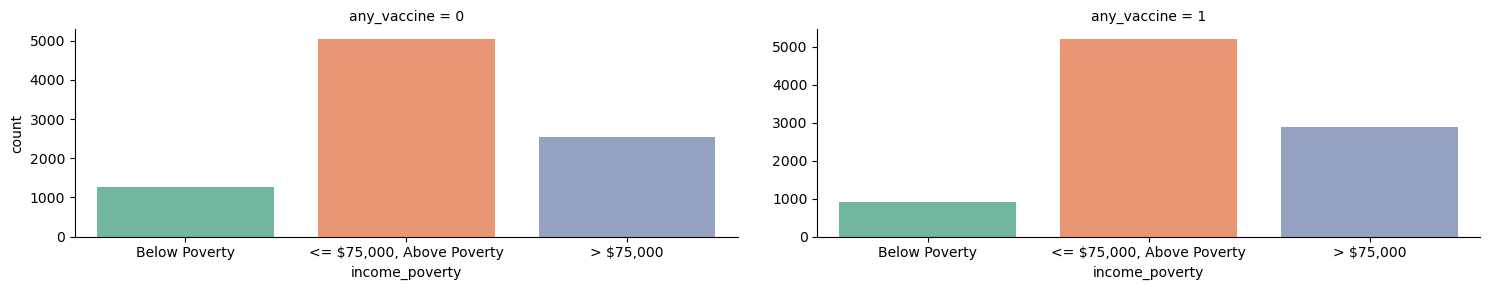

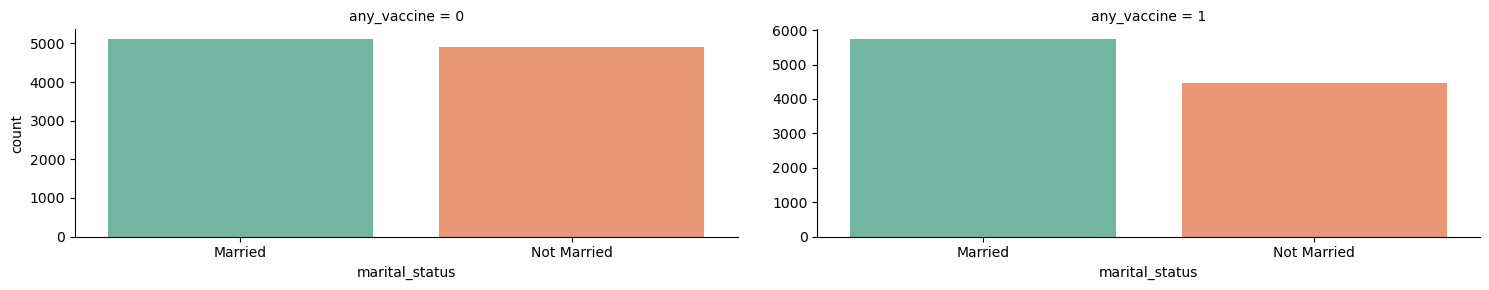

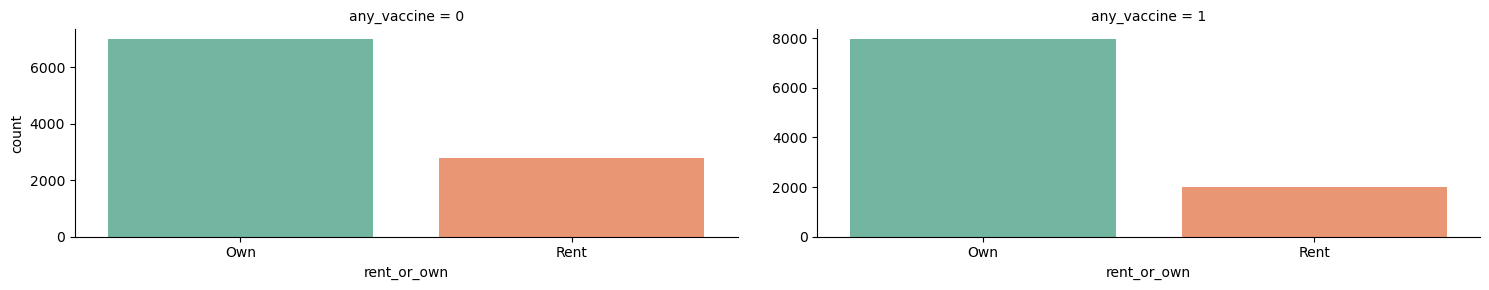

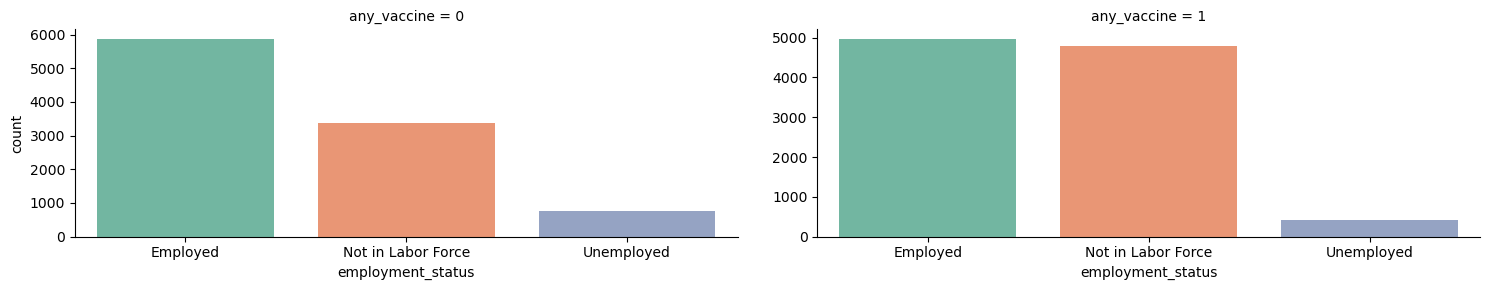

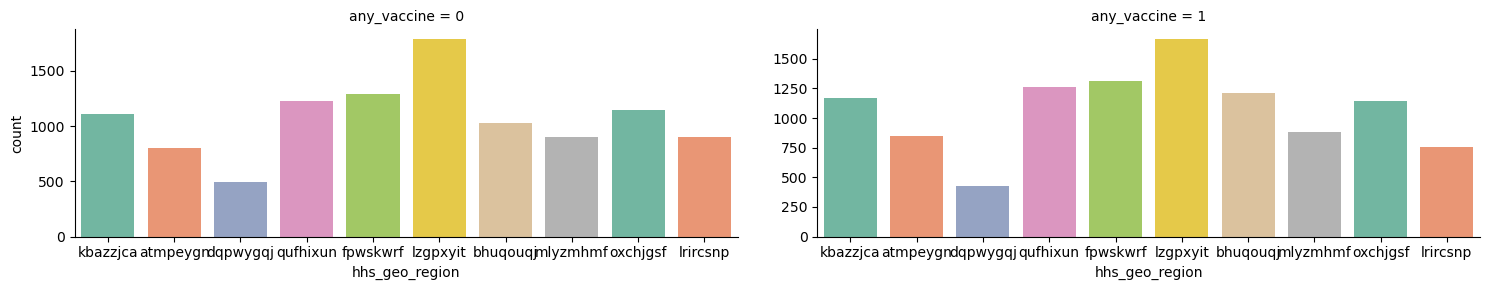

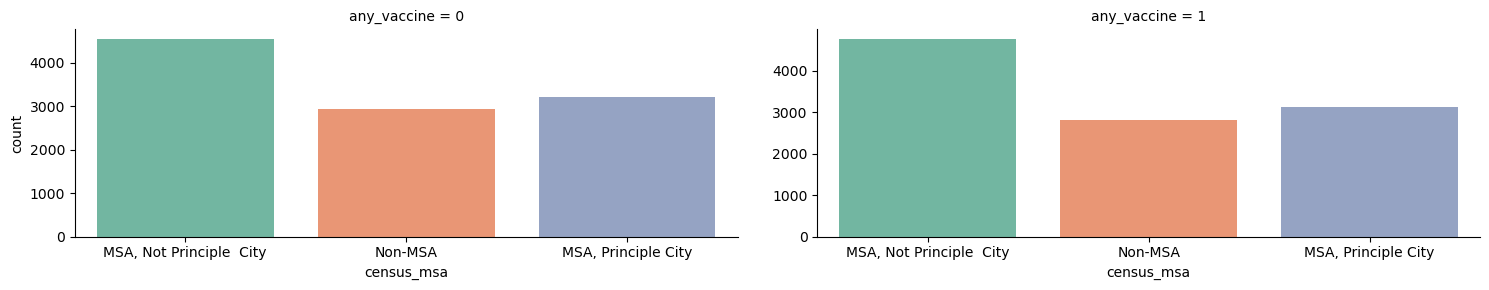

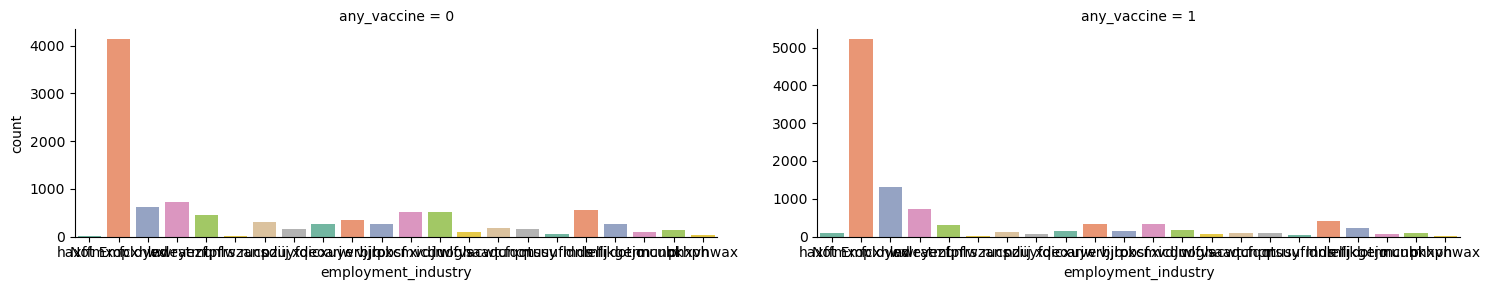

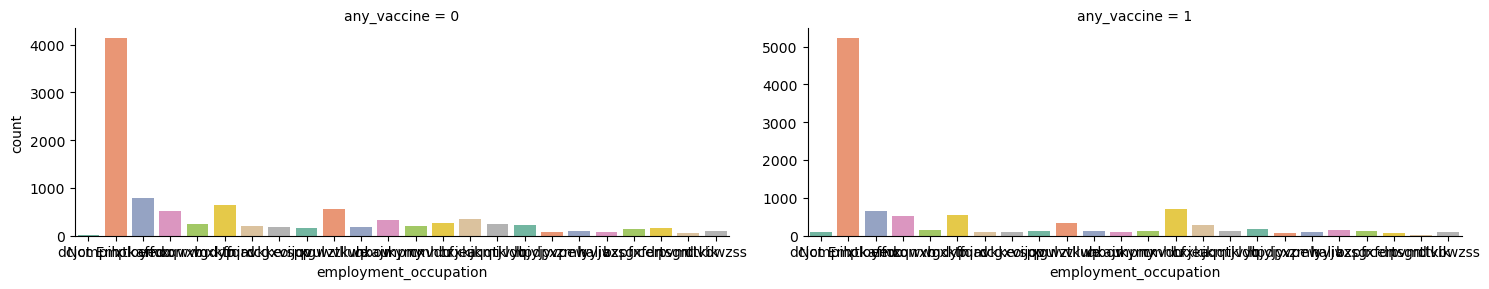

In [22]:
for col in df.select_dtypes(include=['object','category']):
    sns.catplot(x = col, kind='count', col='any_vaccine', data=df, sharey=False, height=3, aspect=2.5, palette='Set2')
plt.tight_layout()

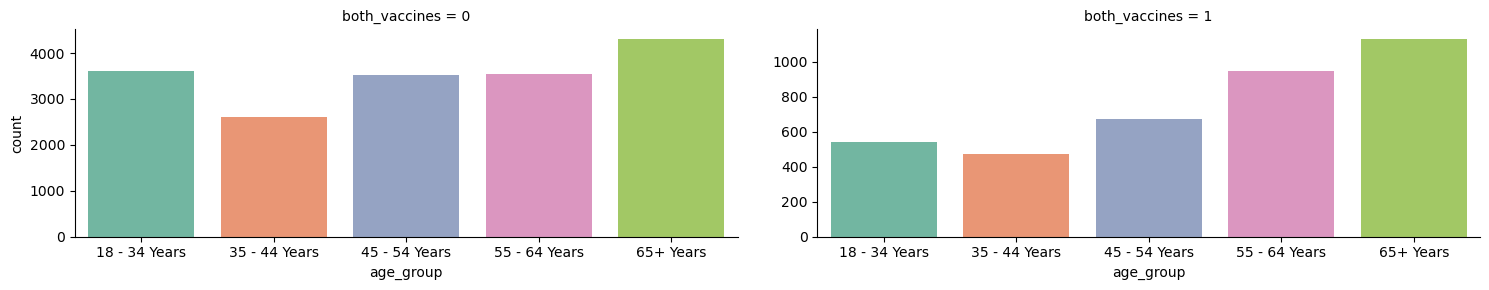

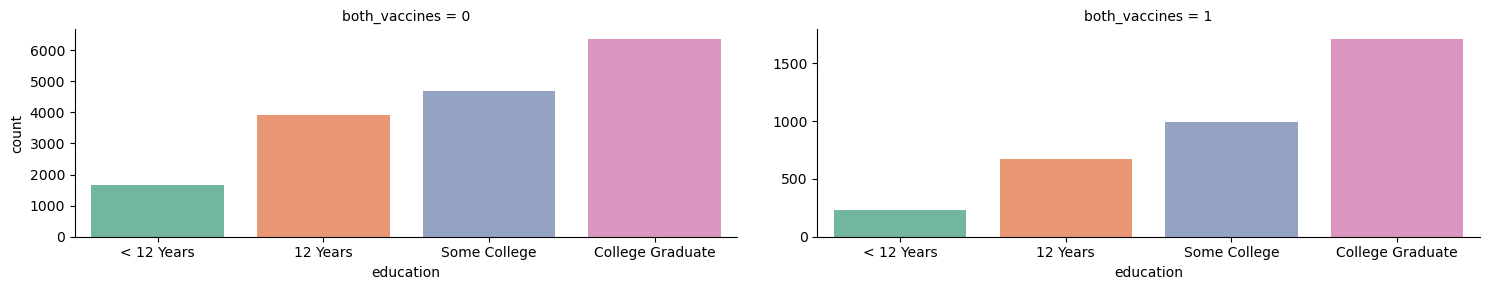

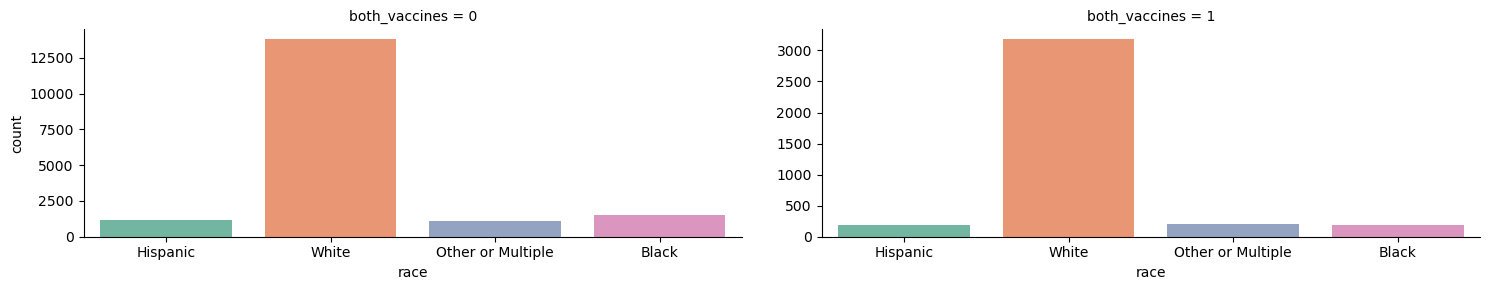

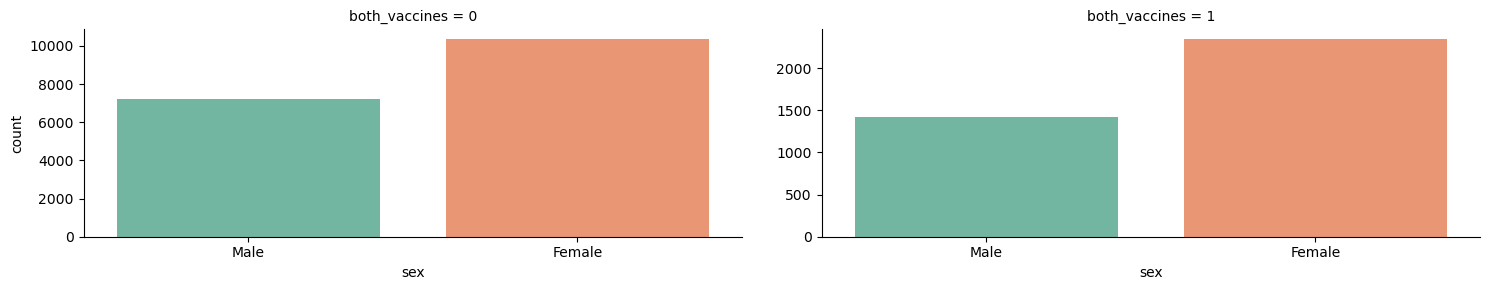

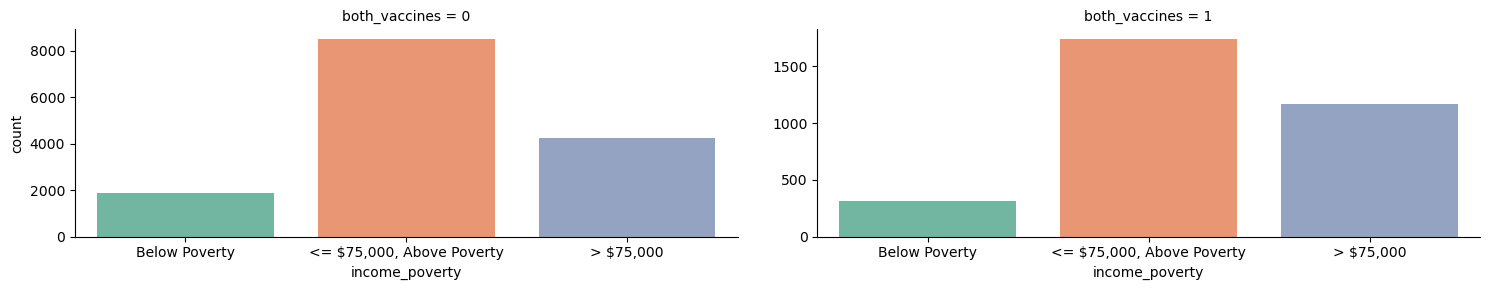

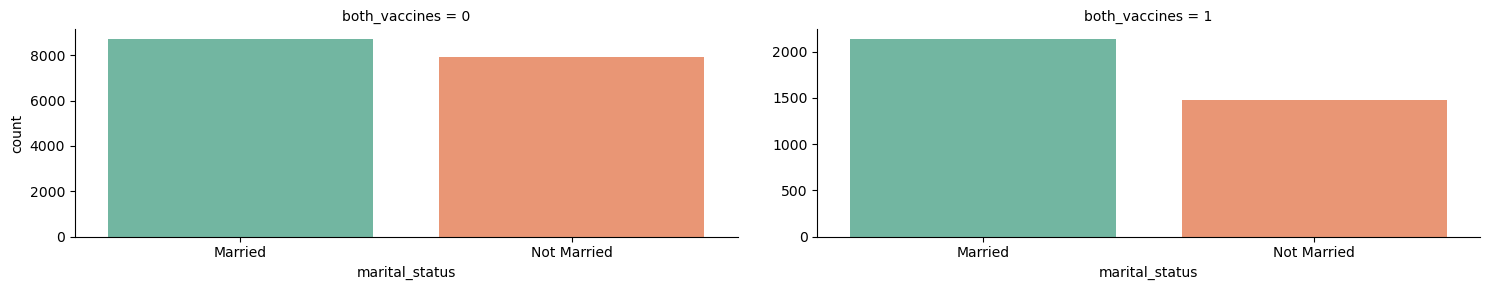

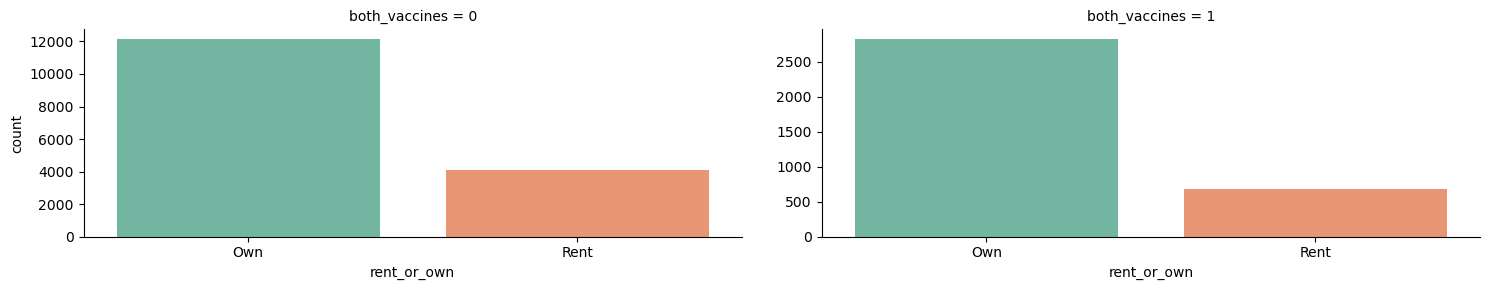

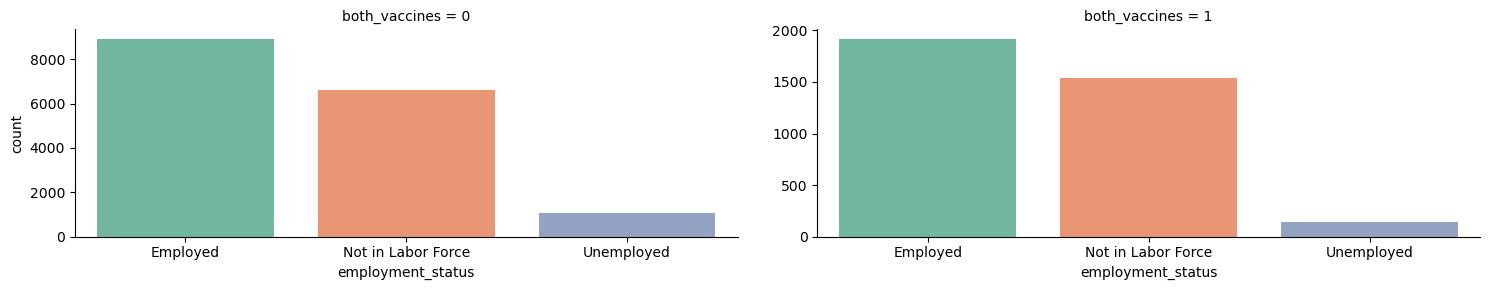

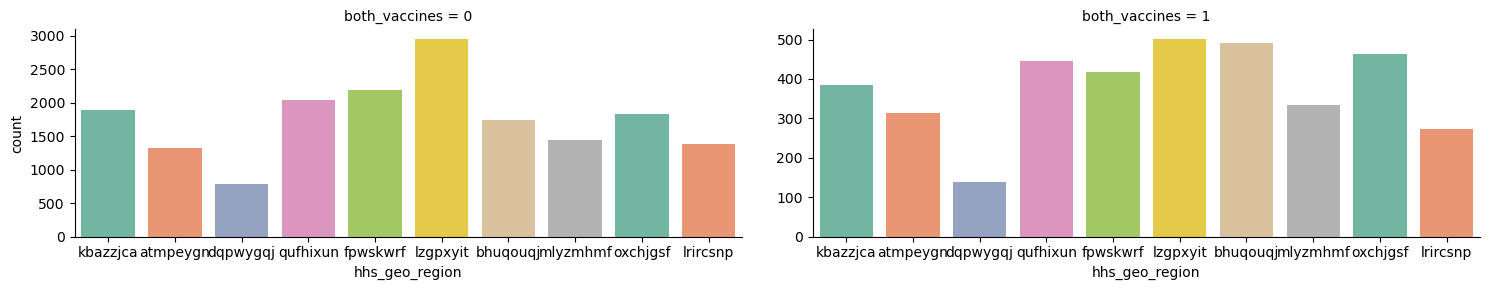

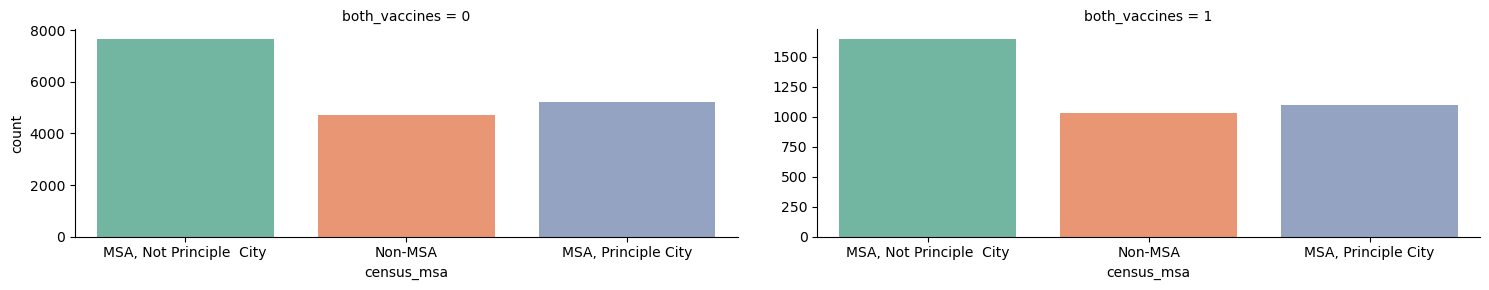

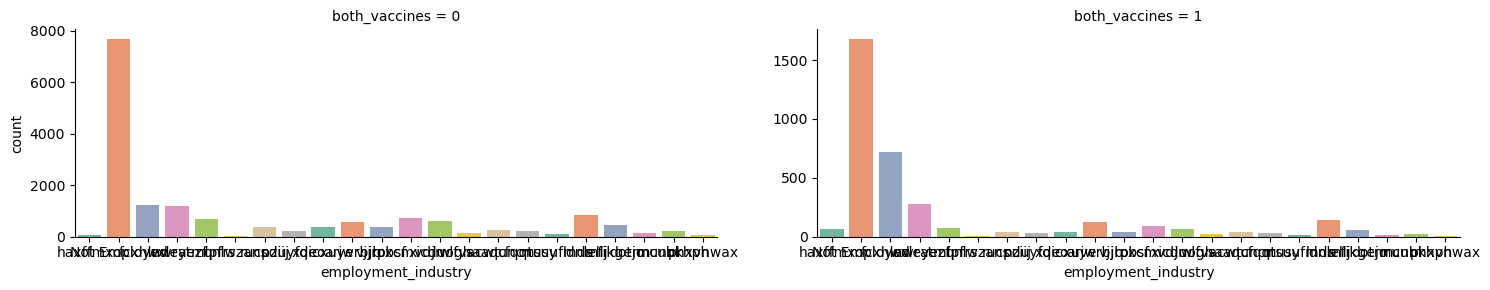

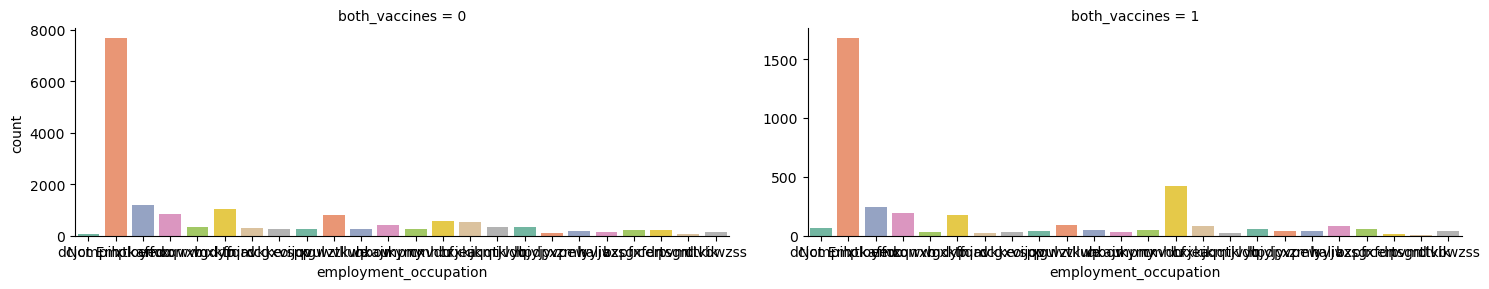

In [23]:
for col in df.select_dtypes(include=['object','category']):
    sns.catplot(x = col, kind='count', col='both_vaccines', data=df, sharey=False, height=3, aspect=2.5, palette='Set2')
plt.tight_layout()

**Features that may be interesting based on EDA:**  
age_group  
health_insurance  
employment_status    
employment_industry    
employment_occupation  
health_insurance  
h1n1_concern  
h1n1_knowledge  
opinion_h1n1_vacc_effective  
opinion_h1n1_risk  
opinion_seas_vacc_effective  
opinion_seas_risk  
overall_opinion_score  


## <a name="section3"></a>Data Preparation

The survey dataset contained a substantial number of unexplained missing values, which need to be removed or imputed to develop a robust classification model. Two strategies were tested for dealing with missing data. The first approach was case-wise deletion to drop rows that contained missing values. The second approach was imputation of the most frequent value (as all attributes analysed were categorical features). Attributes were encoded using OrdinalEncoder for ordinal features, and OneHotEncoder for nominal features.

### Helper Functions

In [24]:
def convert_to_categorical(df):
    for col in df.columns:
        df[col] = df[col].astype('category')

def prepare_X_for_ML(dfX):  
    # Change employment details of non-employed people to 'Unemployed'
    dfX.loc[dfX['employment_status'].isin(['Not in Labor Force', 'Unemployed']),['employment_occupation', 'employment_industry']] = "Not Employed"
    dfX[dfX['employment_status'].isin(['Not in Labor Force', 'Unemployed'])][['employment_status','employment_occupation', 'employment_industry']].head(3)

    # Null values for vaccine imputations can be imputed as '3', which refers to the neutral response of 'Don't Know'.
    for col in ['opinion_seas_sick_from_vacc', 
                'opinion_seas_risk', 
                'opinion_seas_vacc_effective', 
                'opinion_h1n1_sick_from_vacc',
                'opinion_h1n1_vacc_effective',
                'opinion_h1n1_risk']:
        dfX.loc[dfX[col].isna(),col] = 3

    # Clarify the ordering of non-numeric ordinal data
    dfX['age_group'] = pd.Categorical(dfX['age_group'], ['18 - 34 Years', '35 - 44 Years', '45 - 54 Years', '55 - 64 Years', '65+ Years'])
    dfX['education'] = pd.Categorical(dfX['education'], ['< 12 Years', '12 Years', 'Some College', 'College Graduate'])
    dfX['income_poverty'] = pd.Categorical(dfX['income_poverty'], ['Below Poverty', '<= $75,000, Above Poverty', '> $75,000'])

    # Make opinion scores more intuitive
    dfX['opinion_h1n1_vacc_effective'] -= 3
    dfX['opinion_h1n1_risk'] -= 3
    dfX['opinion_h1n1_sick_from_vacc'] -= 3
    dfX['opinion_seas_vacc_effective'] -= 3
    dfX['opinion_seas_risk'] -= 3
    dfX['opinion_seas_sick_from_vacc'] -= 3

    # Additional attributes for features
    dfX.insert(dfX.columns.get_loc('opinion_seas_sick_from_vacc')+1, 'overall_h1n1_score', (
        dfX['opinion_h1n1_vacc_effective'] +
        dfX['opinion_h1n1_risk'] +
        dfX['opinion_h1n1_sick_from_vacc'])
    )
    dfX.insert(dfX.columns.get_loc('overall_h1n1_score')+1, 'overall_seas_score', (
        dfX['opinion_seas_vacc_effective'] +
        dfX['opinion_seas_risk'] +
        dfX['opinion_seas_sick_from_vacc'])
    )
    dfX.insert(dfX.columns.get_loc('overall_seas_score')+1, 'overall_opinion_score', (
        dfX['opinion_h1n1_vacc_effective'] +
        dfX['opinion_h1n1_risk'] +
        dfX['opinion_h1n1_sick_from_vacc'] +
        dfX['opinion_seas_vacc_effective'] +
        dfX['opinion_seas_risk'] +
        dfX['opinion_seas_sick_from_vacc'])
    )
    
def prepare_Y_for_ML(dfY):       
    # Additional attributes for labels
    dfY.insert(dfY.columns.get_loc('seasonal_vaccine')+1, 'any_vaccine', 
          [1 if (row['h1n1_vaccine'] == 1 or row['seasonal_vaccine'] == 1) else 0 for index, row in dfY.iterrows()]) # Recieved at least one vaccine
    dfY.insert(dfY.columns.get_loc('any_vaccine')+1, 'both_vaccines', 
          [1 if (row['h1n1_vaccine'] == 1 and row['seasonal_vaccine'] == 1) else 0 for index, row in dfY.iterrows()]) # Recieved both h1n1 and seasonal vaccine

def print_cleaned_data_characteristics(dfX, dfY):
    printmd("**Features Dataframe:**")
    printmd("**Shape:**")
    print(dfX.shape)
    printmd("**Number of null values per column:**")
    print(dfX.isna().sum().sort_values(ascending=False))
    printmd("**Number of rows with X missing values:**")
    display(dfX.isnull().sum(axis=1).sort_values(ascending=False).value_counts().sort_index())
    printmd("**Most Frequent Answers:**")
    display(dfX.mode())

    print('\n=======\n')

    printmd("**Labels Dataframe:**")
    printmd("**Shape:**")
    print(dfY.shape)
    printmd("**Number of null values per column:**")
    print(dfY.isna().sum().sort_values(ascending=False))
    printmd("**Number of rows with X missing values:**")
    display(dfY.isnull().sum(axis=1).sort_values(ascending=False).value_counts().sort_index())
    printmd("**Most Frequent Answers:**")
    display(dfY.mode())    
    
def clean_and_drop(dfX, dfY, columns_to_drop, print_details=False):
    # Clean the data
    preliminary_clean(dfX, dfY)
    prepare_X_for_ML(dfX)
    prepare_Y_for_ML(dfY)

    dfX.drop(columns_to_drop, inplace=True, axis=1, errors='ignore')

    if print_details:
        print_cleaned_data_characteristics(dfX, dfY)
        
    i = set((dfX.index))
    dfX.dropna(inplace=True)
    i = i.symmetric_difference(set((dfX.index)))
    dfY.drop(list(i), inplace=True)

    return preprocessing.fit_transform(dfX)

def clean_and_impute(dfX, dfY, columns_to_drop, print_details=False):
    # Clean the data
    preliminary_clean(dfX, dfY)
    prepare_X_for_ML(dfX)
    prepare_Y_for_ML(dfY)

    dfX.drop(columns_to_drop, inplace=True, axis=1, errors='ignore')

    if print_details:
        print_cleaned_data_characteristics(dfX, dfY)

    return preprocessing.fit_transform(dfX) 

### Data Preprocessing Pipelines

In [25]:
def create_preprocessing_pipelines(imputer_variables, categorical_encoder, orderinal_encoder):
    strategy, fill = imputer_variables
    cat_unknown_handling = categorical_encoder
    ord_unknown_handling, ord_unknown_value = orderinal_encoder
    
    categorical_pipeline = make_pipeline(SimpleImputer(strategy=strategy, fill_value=fill), 
                                         OneHotEncoder(handle_unknown=cat_unknown_handling))
    ordinal_pipeline = make_pipeline(SimpleImputer(strategy=strategy, fill_value=fill), 
                                         OrdinalEncoder(handle_unknown=ord_unknown_handling,
                                                        unknown_value=ord_unknown_value))  
    return categorical_pipeline, ordinal_pipeline

def process(pipelines):
    categorical_pipeline, ordinal_pipeline = pipelines
    preprocessing = make_column_transformer(
        (categorical_pipeline, make_column_selector(dtype_include=object)),
        (ordinal_pipeline, make_column_selector(dtype_include=['category', 'float64']))
    )
    return preprocessing
    
pipelines = create_preprocessing_pipelines(("most_frequent", None), ("error"), ("error", None)) 
preprocessing = process(pipelines) 
    
# Create fresh copies of the datasets
dfXd = dfX.copy()
dfYd = dfY.copy()

dfXi = dfX.copy()
dfYi = dfY.copy()

# Iteratively changed and re-run to investigate feature importance
columns_to_drop = [
    #'age_group',
    #'employment_status',
    #'employment_industry',
    #'employment_occupation',
    #'health_insurance',
    #'health_worker',
    #'education',
    #'race',
    #'sex',
    #'income_poverty',
    #'marital_status',
    #'rent_or_own',
    #'hhs_geo_region',
    #'census_msa',
    #'household_adults',
    #'household_children',
    #'child_under_6_months',
    #'h1n1_concern',
    #'h1n1_knowledge',
    #'opinion_h1n1_vacc_effective',
    #'opinion_h1n1_risk',
    #'opinion_h1n1_sick_from_vacc',
    #'opinion_seas_vacc_effective',
    #'opinion_seas_risk',
    #'opinion_seas_sick_from_vacc',
    #'overall_h1n1_score',
    #'overall_seas_score',
    #'overall_opinion_score'
]

# Preprocess datasets
dfXd_encoded = clean_and_drop(dfXd, dfYd, columns_to_drop)
dfXi_encoded = clean_and_impute(dfXi, dfYi, columns_to_drop)

## Quickfire Model Training (using standard parameters)

The problem is an offline, multilabel classification task. Due to the size of the dataset and the lack of continuous data input,
batch learning is suitable. Several quick models were iteratively trained and compared, with features being dropped if they
provided no useful information to the model. These models were created using the Python sklearn package.


In [26]:
def generate_quick_model(dfX, dfY, model, features=None):

    # Create multilabel array containing all labels
    y_h1n1 = (dfY.iloc[:,0] == 1)
    y_seas = (dfY.iloc[:,1] == 1)
    y_any = (dfY.iloc[:,2] == 1)
    y_both = (dfY.iloc[:,3] == 1)
    y_multilabel = np.c_[y_h1n1, y_seas, y_any, y_both]
    
    # Train model
    clf = model()
    clf.fit(dfX, y_multilabel)
    
    if model in [RandomForestClassifier, ExtraTreesClassifier]:
        # Display features based on importance weights
        #printmd(f'**Weighted Features:**')
        #display(preprocessing.get_feature_names_out()[(SelectFromModel(clf).get_support())])
        # Output feature importance
        #printmd(f'**Feature Importances:**')
        #for score, name in zip(clf.feature_importances_, features):
            #print(round(score, 4), name)
        pass
        
    elif model == DecisionTreeClassifier:
        # Visualise trained Decision Tree
        #visualised_tree = export_graphviz(
            #clf,
            #feature_names=preprocessing.get_feature_names_out(),
            #class_names=dfY.columns,
            #max_depth=2,
            #rounded=True,
            #filled=True,
            #proportion=True
        #)
        #display(Source(visualised_tree))
        pass
           
    evaluate_model(dfX, dfY, y_multilabel, clf)
        
def evaluate_model(dfX, dfY, y_multilabel, classifier):
    # Generate cross-validated estimates
    scores = cross_val_score(classifier, dfX, y_multilabel)
    print(f"Cross-validation score: {scores.mean():.2f} accuracy with a standard deviation of {scores.std():.2f}")
    y_pred = cross_val_predict(classifier, dfX, y_multilabel)
    
    # Evaluate model performance using confusion matrix
    printmd(f'**Confusion Matrices:**')
    cm = multilabel_confusion_matrix(dfY, y_pred)
    for i in range(0, 4):
        printmd(f'**{dfY.columns[i]}**')  
        display(cm[i])
    
    # Display Precision
    #printmd(f'**Precision Score:**')
    #printmd(f'Macro:')
    #display(precision_score(y_multilabel, y_pred, average="macro"))
    #printmd(f'Weighted:')
    #display(precision_score(y_multilabel, y_pred, average="weighted"))
    
    # Display F1 scores
    #printmd(f'**F1 Score:**')
    #printmd(f'Macro:')
    #display(f1_score(y_multilabel, y_pred, average="macro"))
    #printmd(f'Weighted:')
    #display(f1_score(y_multilabel, y_pred, average="weighted"))
    
    # Display classification report
    clf_report = classification_report(y_multilabel,
                                       y_pred,
                                       target_names= ['H1N1', 'Seasonal', 'Any Vaccine', 'Both Vaccines'],
                                       output_dict=True,
                                       zero_division=0)
    fig, ax = plt.subplots(figsize=(5,5))
    display(sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-1].T, annot=True, cmap='flare'))
    plt.show()

## Preprocessing Approach 1: Casewise Deletion

### Decision Tree Classifier

Cross-validation score: 0.52 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[5333, 1474],
       [1428, 1522]], dtype=int64)

**seasonal_vaccine**

array([[3353, 1543],
       [1468, 3393]], dtype=int64)

**any_vaccine**

array([[2876, 1535],
       [1444, 3902]], dtype=int64)

**both_vaccines**

array([[5988, 1304],
       [1274, 1191]], dtype=int64)

<Axes: >

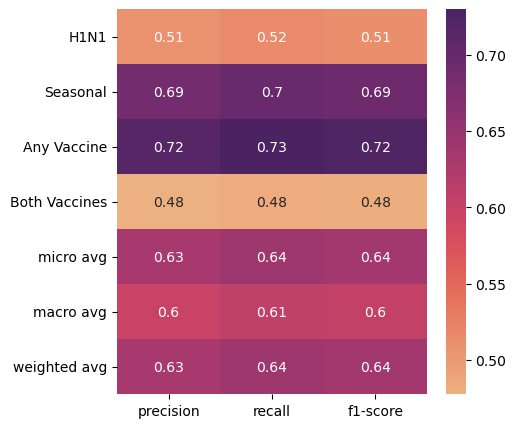

### Random Forest Classifier

Cross-validation score: 0.59 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[6273,  534],
       [1459, 1491]], dtype=int64)

**seasonal_vaccine**

array([[3812, 1084],
       [1147, 3714]], dtype=int64)

**any_vaccine**

array([[3258, 1153],
       [1089, 4257]], dtype=int64)

**both_vaccines**

array([[6867,  425],
       [1365, 1100]], dtype=int64)

<Axes: >

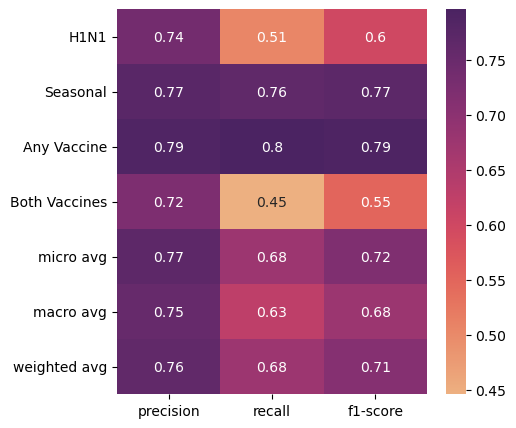

### Extra Trees Classifier

Cross-validation score: 0.58 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[6257,  550],
       [1516, 1434]], dtype=int64)

**seasonal_vaccine**

array([[3800, 1096],
       [1154, 3707]], dtype=int64)

**any_vaccine**

array([[3249, 1162],
       [1068, 4278]], dtype=int64)

**both_vaccines**

array([[6855,  437],
       [1380, 1085]], dtype=int64)

<Axes: >

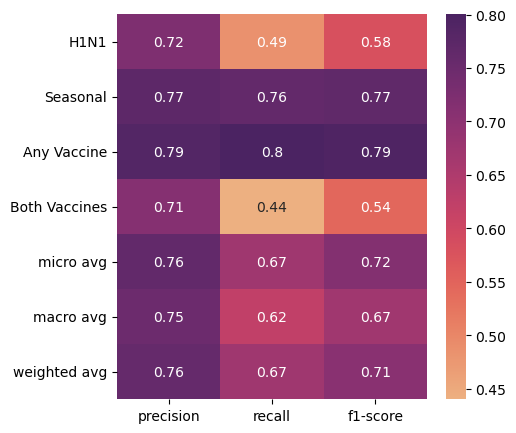

In [27]:
printmd(f'## Preprocessing Approach 1: Casewise Deletion')

printmd(f'### Decision Tree Classifier')
generate_quick_model(dfXd_encoded, dfYd, DecisionTreeClassifier)

printmd(f'### Random Forest Classifier')
generate_quick_model(dfXd_encoded, dfYd, RandomForestClassifier, dfXd.columns)

printmd(f'### Extra Trees Classifier')
generate_quick_model(dfXd_encoded, dfYd, ExtraTreesClassifier, dfXd.columns)

## Preprocessing Approach 2: Mode Imputation

### Decision Tree Classifier

Cross-validation score: 0.51 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[13797,  3023],
       [ 2796,  1743]], dtype=int64)

**seasonal_vaccine**

array([[7788, 3658],
       [3482, 6431]], dtype=int64)

**any_vaccine**

array([[6953, 3720],
       [3533, 7153]], dtype=int64)

**both_vaccines**

array([[14974,  2619],
       [ 2403,  1363]], dtype=int64)

<Axes: >

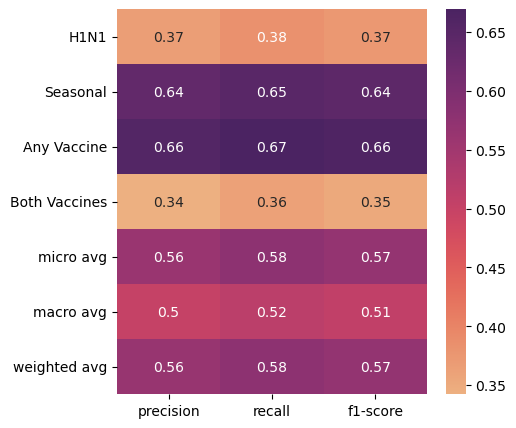

### Random Forest Classifier

Cross-validation score: 0.60 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[16167,   653],
       [ 3342,  1197]], dtype=int64)

**seasonal_vaccine**

array([[9050, 2396],
       [2803, 7110]], dtype=int64)

**any_vaccine**

array([[8072, 2601],
       [2693, 7993]], dtype=int64)

**both_vaccines**

array([[17105,   488],
       [ 2867,   899]], dtype=int64)

<Axes: >

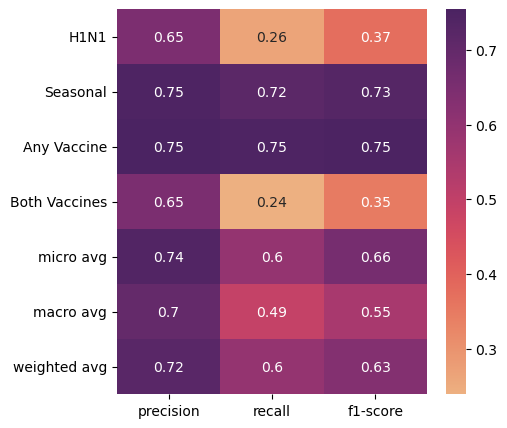

### Extra Trees Classifier

Cross-validation score: 0.59 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[16184,   636],
       [ 3427,  1112]], dtype=int64)

**seasonal_vaccine**

array([[9043, 2403],
       [2879, 7034]], dtype=int64)

**any_vaccine**

array([[8058, 2615],
       [2756, 7930]], dtype=int64)

**both_vaccines**

array([[17101,   492],
       [ 2939,   827]], dtype=int64)

<Axes: >

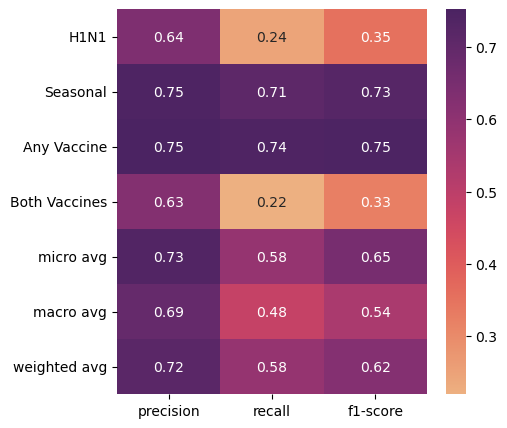

In [28]:
printmd(f'## Preprocessing Approach 2: Mode Imputation')

printmd(f'### Decision Tree Classifier')
generate_quick_model(dfXi_encoded, dfYi, DecisionTreeClassifier)

printmd(f'### Random Forest Classifier')
generate_quick_model(dfXi_encoded, dfYi, RandomForestClassifier, dfXi.columns)

printmd(f'### Extra Trees Classifier')
generate_quick_model(dfXi_encoded, dfYi, ExtraTreesClassifier, dfXi.columns)

## Feature Selection 

In [29]:
columns_to_drop = [
    'employment_status',
    'employment_industry',
    'health_worker',
    'education',
    'race',
    'sex',
    'marital_status',
    'rent_or_own',
    'hhs_geo_region',
    'census_msa',
    'child_under_6_months',
    'overall_seas_score',
    'overall_opinion_score'
]

printmd(f'## Preprocessing Approach 1: Casewise Deletion')

# Create fresh copies of the datasets
dfXd = dfX.copy()
dfYd = dfY.copy()
dfXd_encoded = clean_and_drop(dfXd, dfYd, columns_to_drop)

display(dfXd.shape)

printmd(f'Dataset prepared.')

printmd(f'## Preprocessing Approach 2: Mode Imputation')

# Create fresh copies of the datasets
dfXi = dfX.copy()
dfYi = dfY.copy()
dfXi_encoded = clean_and_impute(dfXi, dfYi, columns_to_drop)

display(dfXi.shape)

printmd(f'Dataset prepared.')

## Preprocessing Approach 1: Casewise Deletion

(9934, 15)

Dataset prepared.

## Preprocessing Approach 2: Mode Imputation

(21359, 15)

Dataset prepared.

## <a name="section4"></a>Hyperparameter Tuning 

Due to processing limitations, RandomizedSearchCV was the chosen approach for hyperparameter tuning. The performance of the model was then tested using the best performing hyperparameters and the unseen test data.

### Helper Functions

In [30]:
def finetune_model(dfX, dfY, model, features, parameters=None):   
    # Create multilabel variable
    y_h1n1 = (dfY.iloc[:,0] == 1)
    y_seas = (dfY.iloc[:,1] == 1)
    y_any = (dfY.iloc[:,2] == 1)
    y_both = (dfY.iloc[:,3] == 1)
    y_multilabel = np.c_[y_h1n1, y_seas, y_any, y_both]
    
    if parameters is None:
        # Default parameters used
        clf = model(random_state=42)
    else:
        if model in [RandomForestClassifier, ExtraTreesClassifier]:
            max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators = parameters
            # Train Classifier
            clf = model(
                n_estimators=n_estimators,
                max_features=max_features,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        else:
            max_depth, max_features, min_samples_leaf, min_samples_split = parameters
            # Train Classifier
            clf = model(
                max_features=max_features,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42)
                
    clf.fit(dfX, y_multilabel) 
    evaluate_model(dfX, dfY, y_multilabel, clf)

### Decision Tree

In [31]:
# Due to random state not being set during hyperparameter tuning,
# RandomizedSearchCV may show different results when this program is run
# compared to those seen in the report.

printmd(f'## Preprocessing Approach 1: Casewise Deletion')

dt_clf = DecisionTreeClassifier(random_state=42)

param_grid = {'max_depth': randint(2, 15),
              'max_features': randint(2, 15),
              'min_samples_leaf': randint(2, 10),
              'min_samples_split': randint(2, 10)  
             }
grid_search = RandomizedSearchCV(dt_clf, param_grid, n_jobs=-1, n_iter=100, cv=3) 
grid_search.fit(dfXd_encoded, dfYd)

display(grid_search.best_params_)

## Preprocessing Approach 1: Casewise Deletion

{'max_depth': 10,
 'max_features': 12,
 'min_samples_leaf': 7,
 'min_samples_split': 5}

### DT: Default Parameters

Cross-validation score: 0.52 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[5448, 1486],
       [1466, 1534]], dtype=int64)

**seasonal_vaccine**

array([[3399, 1583],
       [1551, 3401]], dtype=int64)

**any_vaccine**

array([[2916, 1578],
       [1545, 3895]], dtype=int64)

**both_vaccines**

array([[6112, 1310],
       [1288, 1224]], dtype=int64)

<Axes: >

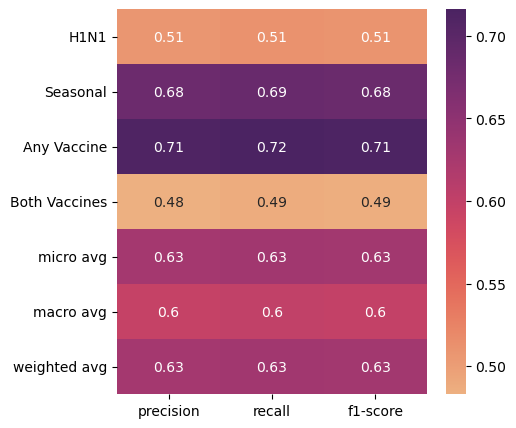

### DT: RandomizedSearchCV Parameters

Cross-validation score: 0.57 accuracy with a standard deviation of 0.02


**Confusion Matrices:**

**h1n1_vaccine**

array([[6146,  788],
       [1525, 1475]], dtype=int64)

**seasonal_vaccine**

array([[3748, 1234],
       [1395, 3557]], dtype=int64)

**any_vaccine**

array([[3271, 1223],
       [1338, 4102]], dtype=int64)

**both_vaccines**

array([[6753,  669],
       [1363, 1149]], dtype=int64)

<Axes: >

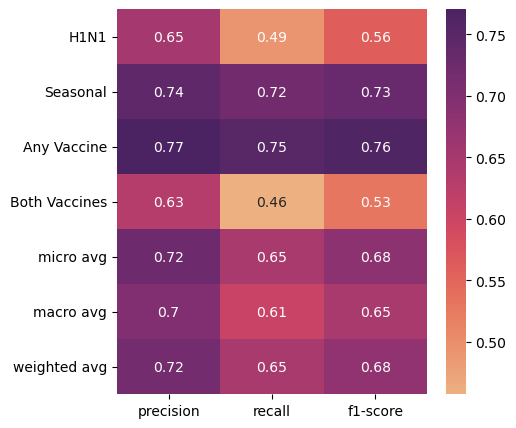

In [32]:
printmd(f'### DT: Default Parameters')
finetune_model(dfXd_encoded, dfYd, DecisionTreeClassifier, dfXd.columns, None)

printmd(f'### DT: RandomizedSearchCV Parameters')
finetune_model(dfXd_encoded, dfYd, DecisionTreeClassifier, dfXd.columns, [9, 13, 3, 5])

In [33]:
# Due to random state not being set during hyperparameter tuning,
# RandomizedSearchCV may show different results when this program is run
# compared to those seen in the report.

printmd(f'## Preprocessing Approach 2: Mode Imputation')

dt_clf = DecisionTreeClassifier(random_state=42)

param_grid = {'max_depth': randint(2, 15),
              'max_features': randint(2, 15),
              'min_samples_leaf': randint(2, 10),
              'min_samples_split': randint(2, 10)  
             }
grid_search = RandomizedSearchCV(dt_clf, param_grid, n_jobs=-1, n_iter=100, cv=3) 
grid_search.fit(dfXi_encoded, dfYi)

display(grid_search.best_params_)

## Preprocessing Approach 2: Mode Imputation

{'max_depth': 10,
 'max_features': 14,
 'min_samples_leaf': 9,
 'min_samples_split': 9}

### DT: Default Parameters

Cross-validation score: 0.51 accuracy with a standard deviation of 0.00


**Confusion Matrices:**

**h1n1_vaccine**

array([[13958,  2862],
       [ 2858,  1681]], dtype=int64)

**seasonal_vaccine**

array([[7828, 3618],
       [3645, 6268]], dtype=int64)

**any_vaccine**

array([[6955, 3718],
       [3705, 6981]], dtype=int64)

**both_vaccines**

array([[15157,  2436],
       [ 2445,  1321]], dtype=int64)

<Axes: >

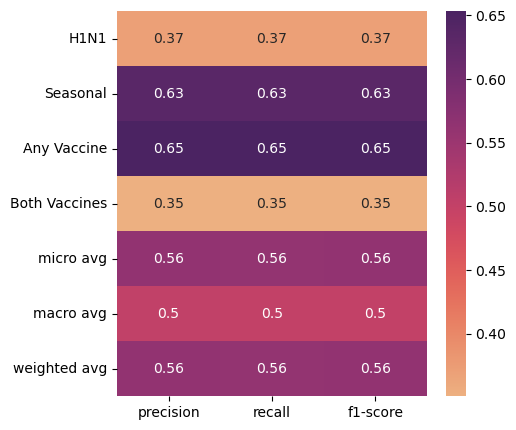

### DT: RandomizedSearchCV Parameters

Cross-validation score: 0.58 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[15864,   956],
       [ 3269,  1270]], dtype=int64)

**seasonal_vaccine**

array([[8803, 2643],
       [3262, 6651]], dtype=int64)

**any_vaccine**

array([[7915, 2758],
       [3180, 7506]], dtype=int64)

**both_vaccines**

array([[16794,   799],
       [ 2821,   945]], dtype=int64)

<Axes: >

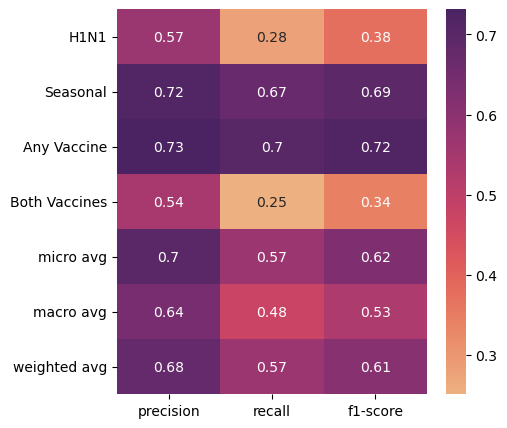

In [34]:
printmd(f'### DT: Default Parameters')
finetune_model(dfXi_encoded, dfYi, DecisionTreeClassifier, dfXi.columns, None)

printmd(f'### DT: RandomizedSearchCV Parameters')
finetune_model(dfXi_encoded, dfYi, DecisionTreeClassifier, dfXi.columns, [13, 13, 8, 9])

## Random Forest

In [35]:
# Due to random state not being set during hyperparameter tuning,
# RandomizedSearchCV may show different results when this program is run
# compared to those seen in the report.

printmd(f'## Preprocessing Approach 1: Casewise Deletion')

rnd_clf = RandomForestClassifier(random_state=42)

param_grid = {'max_depth': randint(2, 15),
              'max_features': randint(2, 15),
              'min_samples_leaf': randint(2, 10),
              'min_samples_split': randint(2, 10),
              'n_estimators': randint(100, 500)   
             }
grid_search = RandomizedSearchCV(rnd_clf, param_grid, n_jobs=-1, n_iter=100, cv=3) 
grid_search.fit(dfXd_encoded, dfYd)

display(grid_search.best_params_)

## Preprocessing Approach 1: Casewise Deletion

{'max_depth': 11,
 'max_features': 14,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 278}

### RFC: Default Parameters

Cross-validation score: 0.58 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[6208,  726],
       [1468, 1532]], dtype=int64)

**seasonal_vaccine**

array([[3821, 1161],
       [1233, 3719]], dtype=int64)

**any_vaccine**

array([[3302, 1192],
       [1174, 4266]], dtype=int64)

**both_vaccines**

array([[6828,  594],
       [1330, 1182]], dtype=int64)

<Axes: >

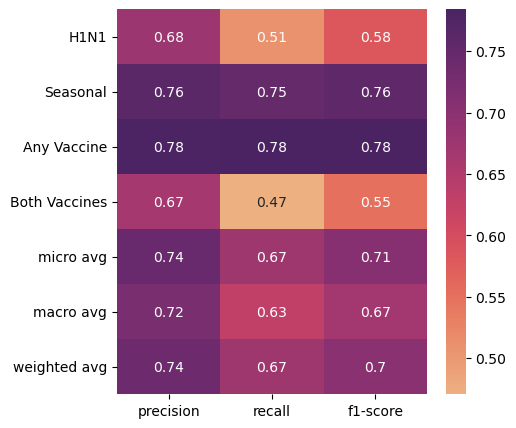

### RFC: RandomizedSearchCV Parameters

Cross-validation score: 0.60 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[6279,  655],
       [1444, 1556]], dtype=int64)

**seasonal_vaccine**

array([[3850, 1132],
       [1154, 3798]], dtype=int64)

**any_vaccine**

array([[3344, 1150],
       [1110, 4330]], dtype=int64)

**both_vaccines**

array([[6876,  546],
       [1331, 1181]], dtype=int64)

<Axes: >

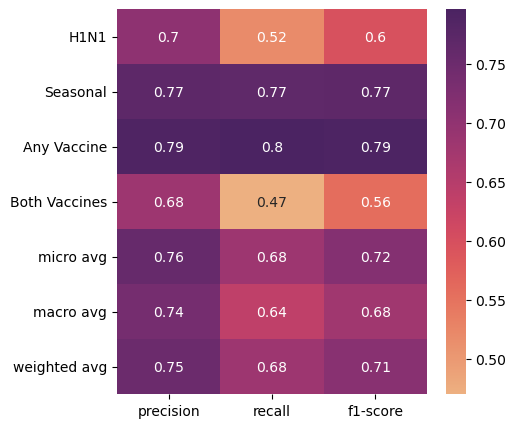

In [36]:
printmd(f'### RFC: Default Parameters')
finetune_model(dfXd_encoded, dfYd, RandomForestClassifier, dfXd.columns, None)

printmd(f'### RFC: RandomizedSearchCV Parameters')
finetune_model(dfXd_encoded, dfYd, RandomForestClassifier, dfXd.columns, [14, 14, 3, 9, 207])

In [37]:
# Due to random state not being set during hyperparameter tuning,
# RandomizedSearchCV may show different results when this program is run
# compared to those seen in the report.

printmd(f'## Preprocessing Approach 2: Mode Imputation')

rnd_clf = RandomForestClassifier(random_state=42)

param_grid = {'max_depth': randint(2, 15),
              'max_features': randint(2, 15),
              'min_samples_leaf': randint(2, 10),
              'min_samples_split': randint(2, 10),
              'n_estimators': randint(200, 500)   
             }
grid_search = RandomizedSearchCV(rnd_clf, param_grid, n_jobs=-1, n_iter=100, cv=3) 
grid_search.fit(dfXi_encoded, dfYi)

display(grid_search.best_params_)

## Preprocessing Approach 2: Mode Imputation

{'max_depth': 11,
 'max_features': 13,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 243}

### RFC: Default Parameters

Cross-validation score: 0.59 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[15774,  1046],
       [ 3111,  1428]], dtype=int64)

**seasonal_vaccine**

array([[8847, 2599],
       [2871, 7042]], dtype=int64)

**any_vaccine**

array([[7899, 2774],
       [2845, 7841]], dtype=int64)

**both_vaccines**

array([[16734,   859],
       [ 2691,  1075]], dtype=int64)

<Axes: >

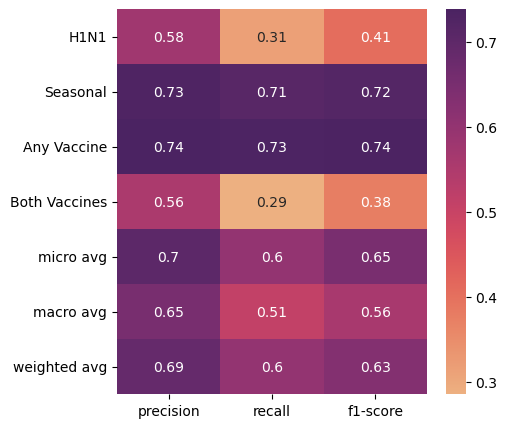

### RFC: RandomizedSearchCV Best Parameters

Cross-validation score: 0.60 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[16123,   697],
       [ 3268,  1271]], dtype=int64)

**seasonal_vaccine**

array([[8980, 2466],
       [2702, 7211]], dtype=int64)

**any_vaccine**

array([[8087, 2586],
       [2699, 7987]], dtype=int64)

**both_vaccines**

array([[17067,   526],
       [ 2835,   931]], dtype=int64)

<Axes: >

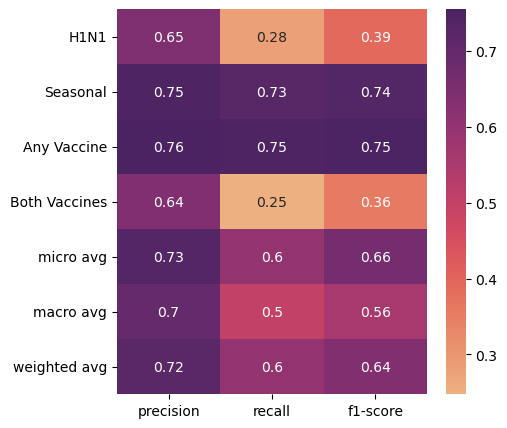

In [38]:
printmd(f'### RFC: Default Parameters')
finetune_model(dfXi_encoded, dfYi, RandomForestClassifier, dfXi.columns, None)

printmd(f'### RFC: RandomizedSearchCV Best Parameters')
finetune_model(dfXi_encoded, dfYi, RandomForestClassifier, dfXi.columns, [13, 14, 5, 2, 252])

## Extra Trees

In [39]:
# Due to random state not being set during hyperparameter tuning,
# RandomizedSearchCV may show different results when this program is run
# compared to those seen in the report.

printmd(f'## Preprocessing Approach 1: Casewise Deletion')

ext_clf = ExtraTreesClassifier(random_state=42)

param_grid = {'max_depth': randint(2, 15),
              'max_features': randint(2, 15),
              'min_samples_leaf': randint(2, 10),
              'min_samples_split': randint(2, 10),
              'n_estimators': randint(100, 500)   
             }
grid_search = RandomizedSearchCV(ext_clf, param_grid, n_jobs=-1, n_iter=100, cv=3) 
grid_search.fit(dfXd_encoded, dfYd)

display(grid_search.best_params_)

## Preprocessing Approach 1: Casewise Deletion

{'max_depth': 14,
 'max_features': 14,
 'min_samples_leaf': 4,
 'min_samples_split': 9,
 'n_estimators': 123}

### EXT: Default Parameters

Cross-validation score: 0.59 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[6174,  760],
       [1470, 1530]], dtype=int64)

**seasonal_vaccine**

array([[3856, 1126],
       [1252, 3700]], dtype=int64)

**any_vaccine**

array([[3344, 1150],
       [1208, 4232]], dtype=int64)

**both_vaccines**

array([[6791,  631],
       [1344, 1168]], dtype=int64)

<Axes: >

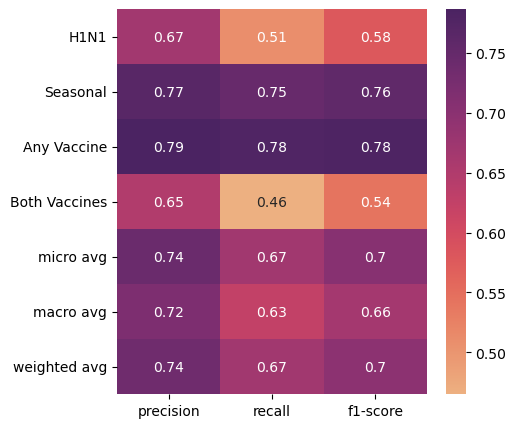

### EXT: RandomizedSearchCV Parameters

Cross-validation score: 0.60 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[6313,  621],
       [1462, 1538]], dtype=int64)

**seasonal_vaccine**

array([[3878, 1104],
       [1175, 3777]], dtype=int64)

**any_vaccine**

array([[3403, 1091],
       [1122, 4318]], dtype=int64)

**both_vaccines**

array([[6894,  528],
       [1316, 1196]], dtype=int64)

<Axes: >

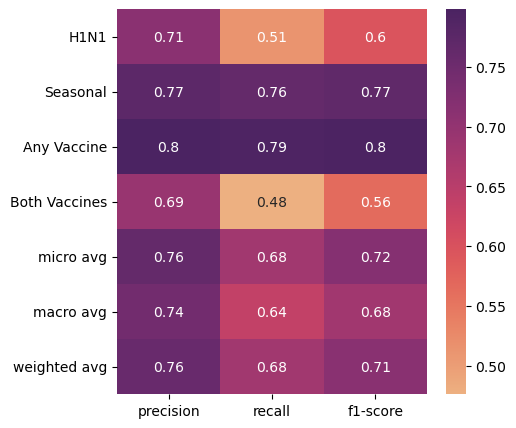

In [40]:
printmd(f'### EXT: Default Parameters')
finetune_model(dfXd_encoded, dfYd, ExtraTreesClassifier, dfXd.columns, None)

printmd(f'### EXT: RandomizedSearchCV Parameters')
finetune_model(dfXd_encoded, dfYd, ExtraTreesClassifier, dfXd.columns, [14, 14, 3, 5, 267])

In [41]:
# Due to random state not being set during hyperparameter tuning,
# RandomizedSearchCV may show different results when this program is run
# compared to those seen in the report.

printmd(f'## Preprocessing Approach 2: Mode Imputation')

ext_clf = ExtraTreesClassifier(random_state=42)

param_grid = {'max_depth': randint(2, 15),
              'max_features': randint(2, 15),
              'min_samples_leaf': randint(2, 10),
              'min_samples_split': randint(2, 10),
              'n_estimators': randint(200, 500)   
             }
grid_search = RandomizedSearchCV(ext_clf, param_grid, n_jobs=-1, n_iter=100, cv=3) 
grid_search.fit(dfXi_encoded, dfYi)

display(grid_search.best_params_)

## Preprocessing Approach 2: Mode Imputation

{'max_depth': 14,
 'max_features': 14,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 231}

### EXT: Default Parameters

Cross-validation score: 0.58 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[15683,  1137],
       [ 3112,  1427]], dtype=int64)

**seasonal_vaccine**

array([[8884, 2562],
       [3068, 6845]], dtype=int64)

**any_vaccine**

array([[7923, 2750],
       [3055, 7631]], dtype=int64)

**both_vaccines**

array([[16667,   926],
       [ 2699,  1067]], dtype=int64)

<Axes: >

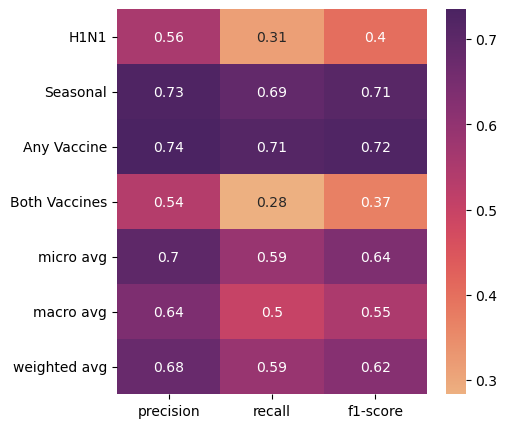

### EXT: RandomizedSearchCV Parameters

Cross-validation score: 0.61 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[16161,   659],
       [ 3291,  1248]], dtype=int64)

**seasonal_vaccine**

array([[9020, 2426],
       [2667, 7246]], dtype=int64)

**any_vaccine**

array([[8118, 2555],
       [2702, 7984]], dtype=int64)

**both_vaccines**

array([[17113,   480],
       [ 2851,   915]], dtype=int64)

<Axes: >

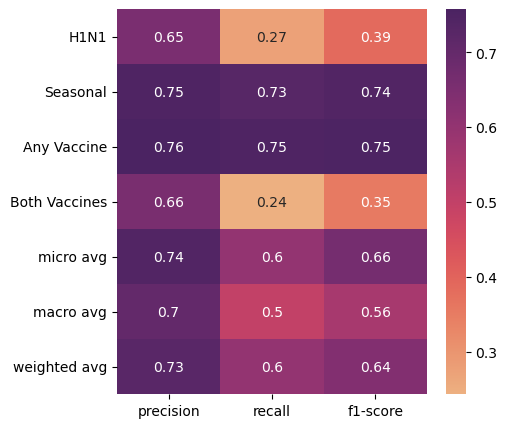

In [42]:
printmd(f'### EXT: Default Parameters')
finetune_model(dfXi_encoded, dfYi, ExtraTreesClassifier, dfXi.columns, None)

printmd(f'### EXT: RandomizedSearchCV Parameters')
finetune_model(dfXi_encoded, dfYi, ExtraTreesClassifier, dfXi.columns, [14, 14, 3, 4, 249])

## <a name="section5"></a>Model Validation

### Helper Functions

In [43]:
def validate_model(X_train, X_test, y_train, y_test, model, features, parameters=None):   
    if parameters is None:
        clf = model(random_state=42)
    else:
        if model in [RandomForestClassifier, ExtraTreesClassifier]:
            max_depth, max_features, min_samples_leaf, min_samples_split, n_estimators = parameters
            # Train Classifier
            clf = model(
                n_estimators=n_estimators,
                max_features=max_features,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        else:
            max_depth, max_features, min_samples_leaf,min_samples_split = parameters
            # Train Classifier
            clf = model(
                max_features=max_features,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42)
        
    clf.fit(X_train, y_train)
            
    # Create multilabel array containing all labels
    y_h1n1 = (y_test.iloc[:,0] == 1)
    y_seas = (y_test.iloc[:,1] == 1)
    y_any = (y_test.iloc[:,2] == 1)
    y_both = (y_test.iloc[:,3] == 1)
    y_multilabel = np.c_[y_h1n1, y_seas, y_any, y_both]
    
    # Generate cross-validated estimates
    h1n1_score = cross_val_score(clf, X_test, y_h1n1, scoring='accuracy')
    print(f"H1N1 Cross-validation score: {h1n1_score.mean():.2f} accuracy with a standard deviation of {h1n1_score.std():.2f}")
    seas_score = cross_val_score(clf, X_test, y_seas, scoring='accuracy')
    print(f"Seasonal Cross-validation score: {seas_score.mean():.2f} accuracy with a standard deviation of {seas_score.std():.2f}")
    any_score = cross_val_score(clf, X_test, y_any, scoring='accuracy')
    print(f"Any Cross-validation score: {any_score.mean():.2f} accuracy with a standard deviation of {any_score.std():.2f}")
    both_score = cross_val_score(clf, X_test, y_both, scoring='accuracy')
    print(f"Both Cross-validation score: {both_score.mean():.2f} accuracy with a standard deviation of {both_score.std():.2f}")
    ml_score = cross_val_score(clf, X_test, y_multilabel, scoring='accuracy')
    print(f"Multilabel Cross-validation score: {ml_score.mean():.2f} accuracy with a standard deviation of {ml_score.std():.2f}")
    y_pred = cross_val_predict(clf, X_test, y_multilabel)
    
    # Evaluate model performance using confusion matrix
    printmd(f'**Confusion Matrices:**')
    cm = multilabel_confusion_matrix(y_test, y_pred)
    for i in range(0, 4):
        printmd(f'**{y_test.columns[i]}**')  
        display(cm[i])
        
    # Display all model evaluation stats
    #print(classification_report(y_multilabel, y_pred, zero_division=0))
    clf_report = classification_report(y_multilabel,
                                       y_pred,
                                       target_names= ['H1N1', 'Seasonal', 'Any Vaccine', 'Both Vaccines'],
                                       output_dict=True,
                                       zero_division=0)
    heatmap = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-1].T, annot=True, cmap='flare', vmax=0.9, vmin=0.2, )
    
    printmd(f'**AUC ROC Score:**')
    y_score = np.transpose([y_pred[:, 1] for y_pred in clf.predict_proba(X_test)])
    roc_auc = roc_auc_score(y_multilabel, y_score, average=None)
    display(roc_auc)
    auc_roc_scores.loc[len(auc_roc_scores)] = roc_auc

### Prepare Datasets

In [44]:
dfX_test = X_test[columns_of_interest].copy()

columns_to_drop = [
    'employment_status',
    'employment_industry',
    'health_worker',
    'education',
    'race',
    'sex',
    'marital_status',
    'rent_or_own',
    'hhs_geo_region',
    'census_msa',
    'child_under_6_months',
    'overall_seas_score',
    'overall_opinion_score'
]

# Create fresh copies of the datasets
dfXd_test = dfX_test.copy() 
dfYd_test = Y_test.copy()

dfXd_test_encoded = clean_and_drop(dfXd_test, dfYd_test, columns_to_drop) # Preprocessing Approach 1

dfXi_test = dfX_test.copy()
dfYi_test = Y_test.copy()

dfXi_test_encoded = clean_and_impute(dfXi_test, dfYi_test, columns_to_drop) # Preprocessing Approach 2

printmd(f'Datasets prepared.')

auc_roc_scores = pd.DataFrame(columns= ['H1N1 Vaccine', 'Seasonal Vaccine', 'Any Vaccine', 'Both Vaccines'])

Datasets prepared.

### Decision Trees:

### DT / Preprocessing 1: Casewise Deletion

H1N1 Cross-validation score: 0.75 accuracy with a standard deviation of 0.01
Seasonal Cross-validation score: 0.74 accuracy with a standard deviation of 0.01
Any Cross-validation score: 0.71 accuracy with a standard deviation of 0.01
Both Cross-validation score: 0.79 accuracy with a standard deviation of 0.02
Multilabel Cross-validation score: 0.54 accuracy with a standard deviation of 0.02


**Confusion Matrices:**

**h1n1_vaccine**

array([[1559,  205],
       [ 418,  323]], dtype=int64)

**seasonal_vaccine**

array([[899, 329],
       [361, 916]], dtype=int64)

**any_vaccine**

array([[ 780,  336],
       [ 366, 1023]], dtype=int64)

**both_vaccines**

array([[1712,  164],
       [ 371,  258]], dtype=int64)

**AUC ROC Score:**

array([0.77111697, 0.80317137, 0.80673772, 0.78609861])

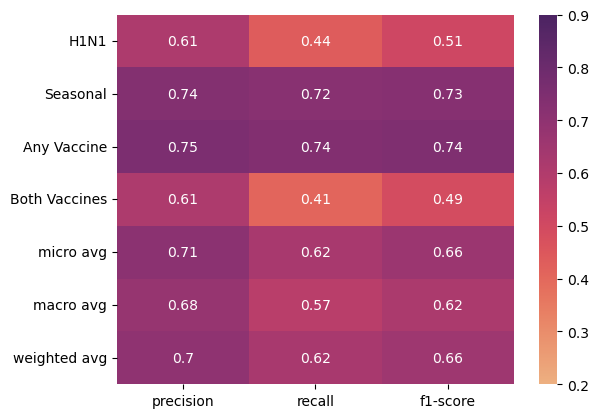

In [45]:
printmd(f'### DT / Preprocessing 1: Casewise Deletion')

validate_model(dfXd_encoded, 
               dfXd_test_encoded, 
               dfYd, 
               dfYd_test, 
               DecisionTreeClassifier, 
               dfXd_test.columns, 
               [9, 13, 3, 5])

### DT / Preprocessing 2: Mode Imputation

H1N1 Cross-validation score: 0.78 accuracy with a standard deviation of 0.01
Seasonal Cross-validation score: 0.71 accuracy with a standard deviation of 0.01
Any Cross-validation score: 0.70 accuracy with a standard deviation of 0.01
Both Cross-validation score: 0.82 accuracy with a standard deviation of 0.01
Multilabel Cross-validation score: 0.56 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[3918,  289],
       [ 843,  292]], dtype=int64)

**seasonal_vaccine**

array([[2140,  682],
       [ 844, 1676]], dtype=int64)

**any_vaccine**

array([[1900,  718],
       [ 845, 1879]], dtype=int64)

**both_vaccines**

array([[4204,  207],
       [ 707,  224]], dtype=int64)

**AUC ROC Score:**

array([0.72460196, 0.78413514, 0.7817024 , 0.74637033])

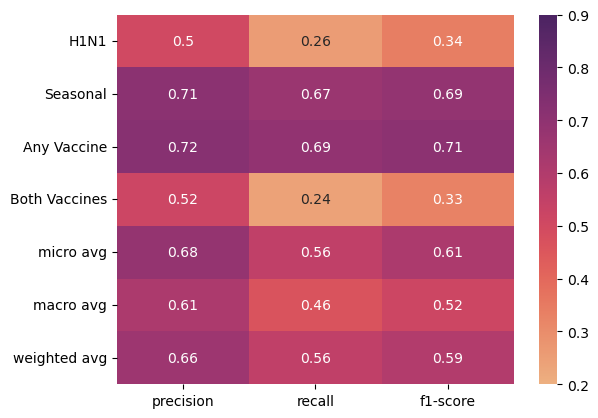

In [46]:
printmd(f'### DT / Preprocessing 2: Mode Imputation')
validate_model(dfXi_encoded, 
               dfXi_test_encoded, 
               dfYi, 
               dfYi_test, 
               DecisionTreeClassifier, 
               dfXi_test.columns, 
               [13, 13, 8, 9])

### Random Forest Classifier:

### RFC / Preprocessing 1: Casewise Deletion

H1N1 Cross-validation score: 0.78 accuracy with a standard deviation of 0.01
Seasonal Cross-validation score: 0.78 accuracy with a standard deviation of 0.02
Any Cross-validation score: 0.76 accuracy with a standard deviation of 0.01
Both Cross-validation score: 0.80 accuracy with a standard deviation of 0.01
Multilabel Cross-validation score: 0.57 accuracy with a standard deviation of 0.02


**Confusion Matrices:**

**h1n1_vaccine**

array([[1597,  167],
       [ 403,  338]], dtype=int64)

**seasonal_vaccine**

array([[ 933,  295],
       [ 276, 1001]], dtype=int64)

**any_vaccine**

array([[ 798,  318],
       [ 280, 1109]], dtype=int64)

**both_vaccines**

array([[1748,  128],
       [ 370,  259]], dtype=int64)

**AUC ROC Score:**

array([0.80617256, 0.84686377, 0.84515852, 0.82815185])

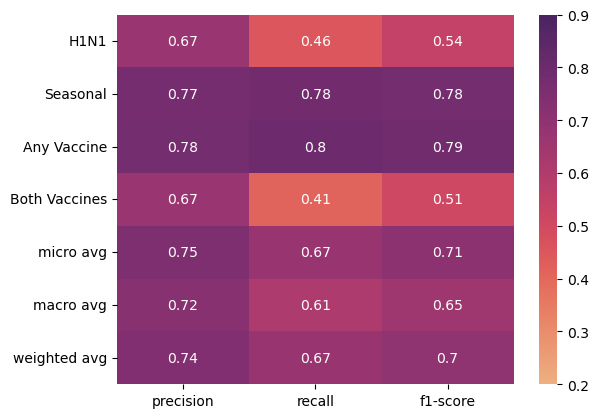

In [47]:
printmd(f'### RFC / Preprocessing 1: Casewise Deletion')
validate_model(dfXd_encoded, 
               dfXd_test_encoded, 
               dfYd, 
               dfYd_test, 
               RandomForestClassifier, 
               dfXd_test.columns, 
               [14, 14, 3, 9, 207])

### RFC / Preprocessing 2: Mode Imputation

H1N1 Cross-validation score: 0.81 accuracy with a standard deviation of 0.00
Seasonal Cross-validation score: 0.76 accuracy with a standard deviation of 0.01
Any Cross-validation score: 0.75 accuracy with a standard deviation of 0.01
Both Cross-validation score: 0.84 accuracy with a standard deviation of 0.01
Multilabel Cross-validation score: 0.59 accuracy with a standard deviation of 0.01


**Confusion Matrices:**

**h1n1_vaccine**

array([[4055,  152],
       [ 872,  263]], dtype=int64)

**seasonal_vaccine**

array([[2170,  652],
       [ 673, 1847]], dtype=int64)

**any_vaccine**

array([[1910,  708],
       [ 670, 2054]], dtype=int64)

**both_vaccines**

array([[4298,  113],
       [ 738,  193]], dtype=int64)

**AUC ROC Score:**

array([0.76566118, 0.82299984, 0.81806214, 0.79122414])

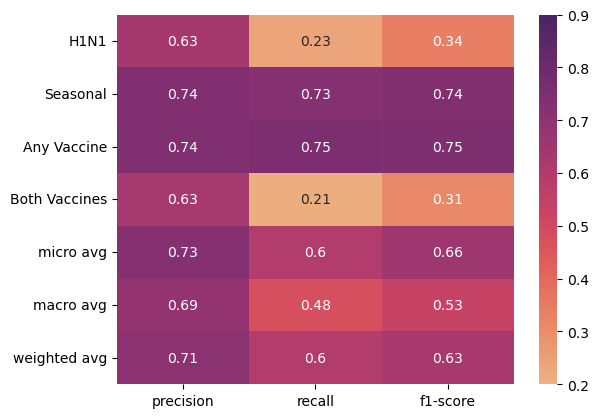

In [48]:
printmd(f'### RFC / Preprocessing 2: Mode Imputation')
validate_model(dfXi_encoded, 
               dfXi_test_encoded, 
               dfYi, 
               dfYi_test, 
               RandomForestClassifier, 
               dfXi_test.columns, 
               [13, 14, 5, 2, 252])

### Extra-Trees:

### EXT / Preprocessing 1: Casewise Deletion

H1N1 Cross-validation score: 0.79 accuracy with a standard deviation of 0.01
Seasonal Cross-validation score: 0.78 accuracy with a standard deviation of 0.02
Any Cross-validation score: 0.78 accuracy with a standard deviation of 0.01
Both Cross-validation score: 0.81 accuracy with a standard deviation of 0.02
Multilabel Cross-validation score: 0.59 accuracy with a standard deviation of 0.03


**Confusion Matrices:**

**h1n1_vaccine**

array([[1614,  150],
       [ 403,  338]], dtype=int64)

**seasonal_vaccine**

array([[ 943,  285],
       [ 274, 1003]], dtype=int64)

**any_vaccine**

array([[ 822,  294],
       [ 287, 1102]], dtype=int64)

**both_vaccines**

array([[1744,  132],
       [ 364,  265]], dtype=int64)

**AUC ROC Score:**

array([0.80560108, 0.8489165 , 0.84705836, 0.82792135])

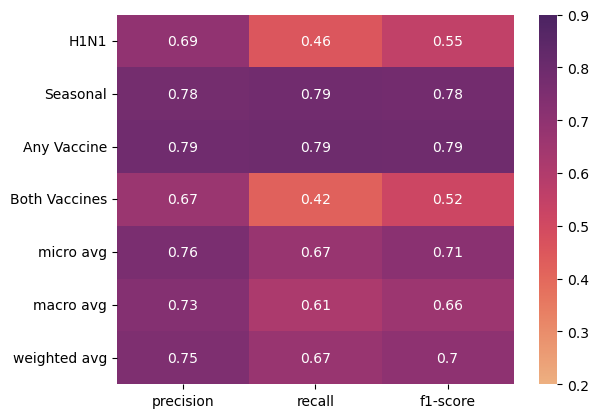

In [49]:
printmd(f'### EXT / Preprocessing 1: Casewise Deletion')
validate_model(dfXd_encoded, 
               dfXd_test_encoded, 
               dfYd, 
               dfYd_test, 
               ExtraTreesClassifier, 
               dfXd_test.columns, 
               [14, 14, 3, 5, 267])

### EXT / Preprocessing 2: Mode Imputation

H1N1 Cross-validation score: 0.81 accuracy with a standard deviation of 0.01
Seasonal Cross-validation score: 0.75 accuracy with a standard deviation of 0.01
Any Cross-validation score: 0.74 accuracy with a standard deviation of 0.01
Both Cross-validation score: 0.84 accuracy with a standard deviation of 0.00
Multilabel Cross-validation score: 0.59 accuracy with a standard deviation of 0.02


**Confusion Matrices:**

**h1n1_vaccine**

array([[4049,  158],
       [ 879,  256]], dtype=int64)

**seasonal_vaccine**

array([[2169,  653],
       [ 667, 1853]], dtype=int64)

**any_vaccine**

array([[1923,  695],
       [ 667, 2057]], dtype=int64)

**both_vaccines**

array([[4296,  115],
       [ 732,  199]], dtype=int64)

**AUC ROC Score:**

array([0.76744392, 0.82552029, 0.81983478, 0.7940408 ])

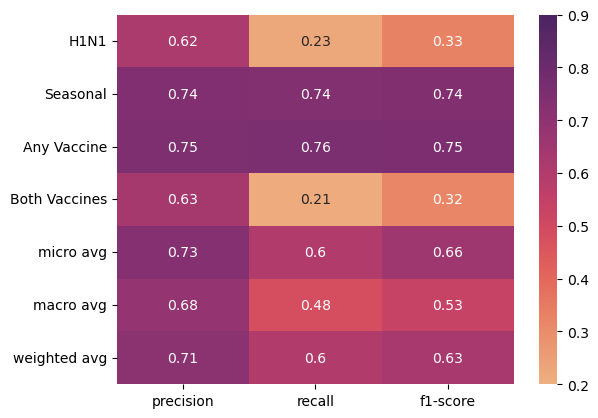

In [50]:
printmd(f'### EXT / Preprocessing 2: Mode Imputation')
validate_model(dfXi_encoded, 
               dfXi_test_encoded, 
               dfYi, 
               dfYi_test, 
               ExtraTreesClassifier,
               dfXi_test.columns,
               [14, 14, 3, 4, 249])

Text(0.5, 1.0, 'AUC ROC Scores')

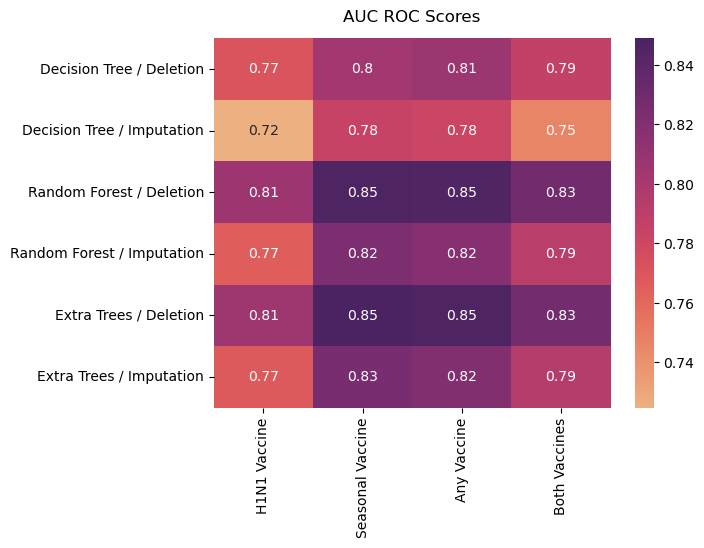

In [51]:
auc_roc_scores.rename(index={
    0: "Decision Tree / Deletion", 
    1: "Decision Tree / Imputation", 
    2: "Random Forest / Deletion", 
    3: "Random Forest / Imputation", 
    4: "Extra Trees / Deletion",
    5: "Extra Trees / Imputation"}, inplace=True)
heatmap = sns.heatmap(auc_roc_scores, annot=True, cmap='flare')
heatmap.set_title('AUC ROC Scores', fontdict={'fontsize':12}, pad=12)

### Model Comparison:

Performance measures allow us to evaluate each of the models. Model accuracy was between 75%-81% for the H1N1 vaccine label, 71%-78% for the seasonal flu vaccine label, and 70%-78% for the any vaccine label; however, due to the skew in some labels, this was not used as a performance metric. Instead, we looked at precision, F1 score and ROC AUC score. 

The casewise deletion approach is shown to perform better than mode imputation across all models. This may be due to the inclusion of the health insurance feature; although this feature provided a high predictive value to the model in exploratory analysis, it is imbalanced and has a high number of missing values, which would disproportionately affect simple imputation methods. 

All models had higher precision and recall for predicting whether someone had received their seasonal vaccine compared to predicting whether someone had received their H1N1 flu vaccine. This may be due to the H1N1 vaccine class being substantially more imbalanced than the seasonal flu vaccine class. 

It can be seen from the precision and recall scores for the H1N1 vaccine that the prediction mistakes being made are mostly false negative predictions. This was preferential to false positive predictions because false positive predictions have the potential to misguide public health policy in a way that prevents vulnerable populations getting the necessary resources. False negatives may also include people who had not received their H1N1 vaccination at the time of survey (as the vaccine had only become publicly available a few months prior) but went to receive it soon afterwards; these people would have a negative H1N1 vaccination label while having features associated with a positive vaccination label.

Both ensemble models (Random Forest and Extra Trees) performed better than the Decision Tree model in almost all metrics across all labels. The Random Forest model and Extra Trees model had similar performances; however, the computational runtime for Extra trees was noticeably faster.

<hr>

The separate pre-processing approaches were seen to have a large effect on the performance of the final model, with casewise 
deletion generally performing better across most cases. However, neither approach is without its limitations. As previously discussed, casewise deletion may cause longer-term issues with the model’s performance, if the missing values in the training dataset were not missing completely at random. For example, if a certain demographic refused to give information regarding their health insurance, then that population would be dropped from the training dataset. The resulting trained model may then perform badly when trying to make predictions about that demographic in future datasets. On the other hand, mode imputation skews the distribution of features towards their most common value, which can cause problems for features with large numbers of missing values. Alternative approaches that could be tried in future studies include testing more advanced imputation methods, or only selecting features that have a maximum threshold for number of missing values. 

The different classifier models used had a smaller effect on the performance of the model. The ensemble methods had higher precision scores and AUC ROC scores compared to the Decision Tree model. This is likely due to the tendency for Decision Tree models to have high variance and overfit the training data. In comparison, both Random Forest and Extra Trees models introduce extra randomness during tree design, only considering a random subset of features during node splitting. By doing this multiple times and comparing the generated decision trees, these models introduce a lower variance.

Both the Extra Trees and Random Forest models perform similarly in performance metrics; as such, future users would be able to choose whether they prefer the faster computational speed of the Extra Trees model or the slightly increased performance of the Random Forest model. However, there is a large downside to these models. The high interpretability of a Decision Tree model is lost in the ensemble methods; as such, if the user values being able to explain the decisions made by the model (for example, if they are designing public health policies), then the Decision Tree model may prove optimal for them despite its slightly lower predictive performance.
<hr>


### Conclusion:

This research creates a classification system for predicting H1N1 flu and seasonal flu vaccination, without the need for behavioural data. Of the parameters covered here, it is concluded that the best overall performance was seen with a casewise imputation approach and an Extra Trees Classifier model; however, if interpretability is important, a Decision Tree Classifier was shown to still perform well. 

These findings are limited by the impact that casewise deletion may have on generalising the model outside of the dataset. The performance of the model for predicting H1N1 flu vaccination status also has room for improvement; if it was possible to collect the data, it would be interesting to assess how many nonvaccinated participants received their H1N1 flu vaccination after the survey data were collected. It would also be of interest to see how the model performs when the behavioural features are included in the process, so that a direct comparison can be made between the models, and the importance of behavioural features can be 
better quantified.